This project largely serves as a means for me to look at my Spotify music listening statistics and to identify trends and undertand how my taste in music has changed over time.
It has been set up such that, with minor modifications, anyone could use it by loading their own listening statistics from Spotify.  

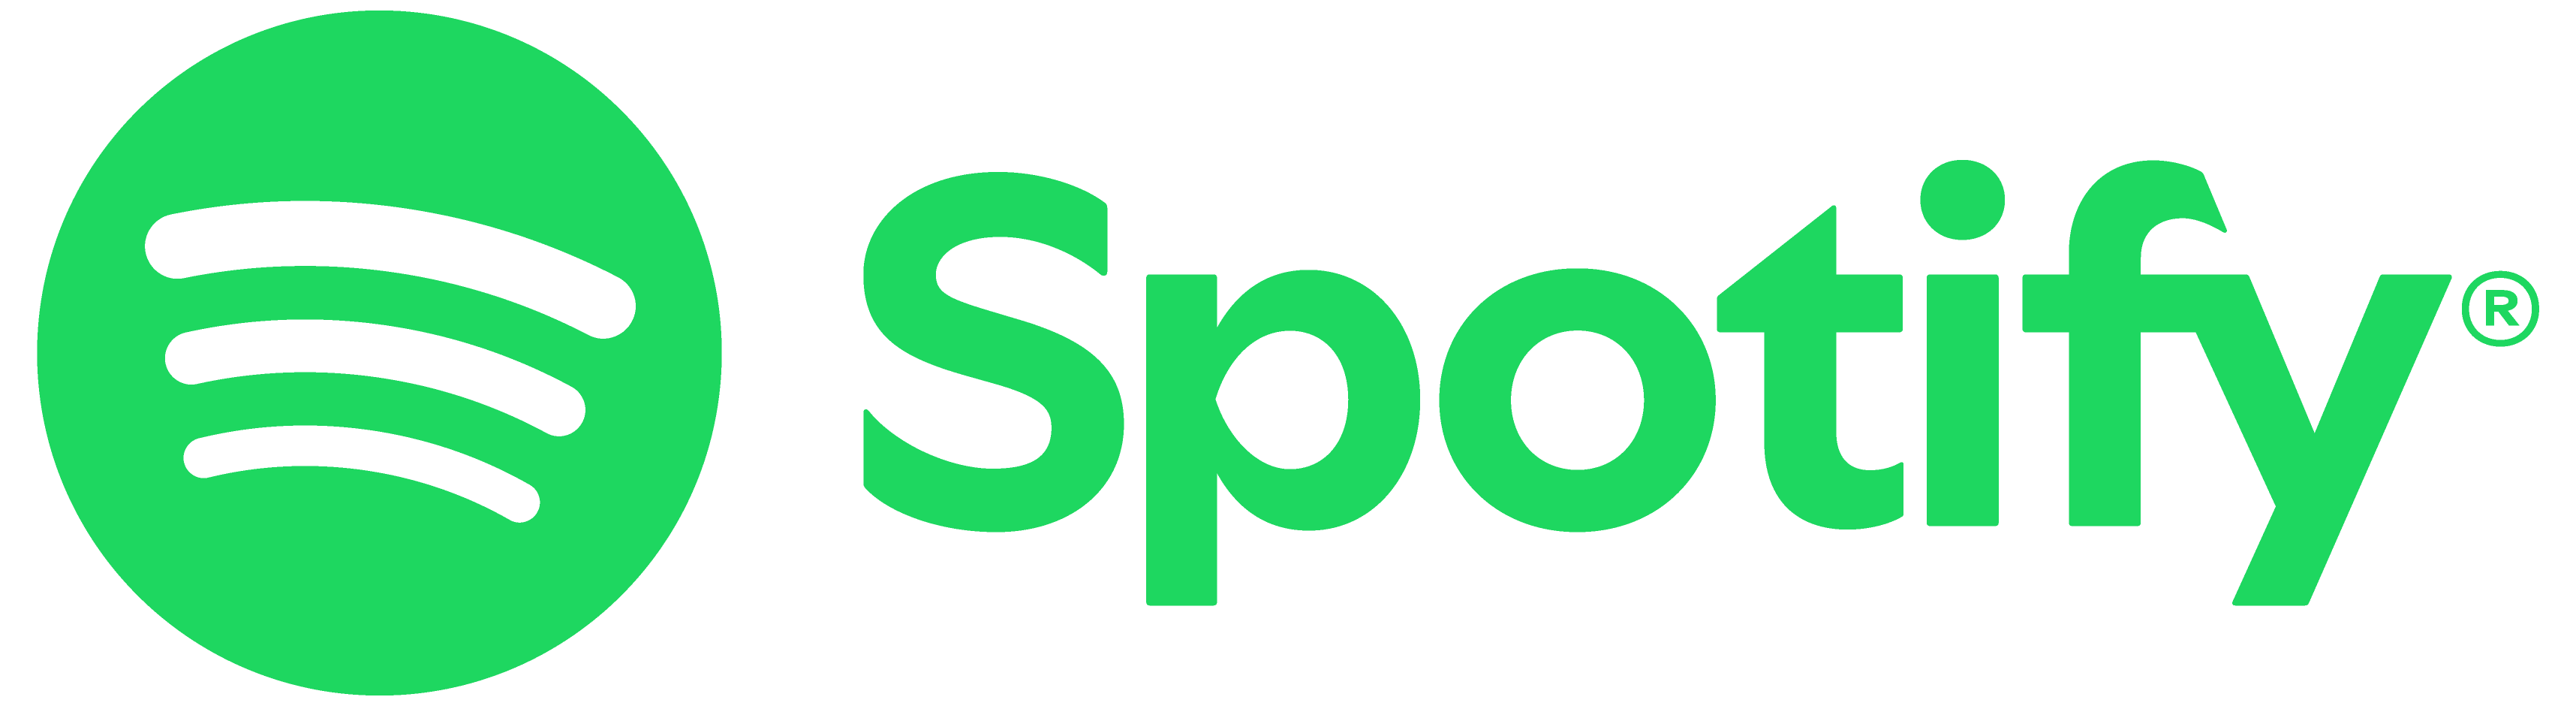

Image Source: https://newsroom.spotify.com/media-kit/logo-and-brand-assets/

In [769]:
import pandas as pd
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina" #higher quality graphs
%matplotlib inline

import time
start_time = time.time()

In [770]:
#importing .json files containing Spotify usage data
file_list = glob.glob('/content/drive/MyDrive/Coding/Spotify Extended Streaming History/*.json')

#file_list = glob.glob('/Users/oneshpunchinilame/Desktop/Spotify Extended Streaming History/*.json')

data_frames = []
for file in file_list:
  data_frames.append(pd.read_json(file))

In [850]:
#Storing all the read-in files in one dataframe
dataframe = pd.concat(data_frames)
original_data = dataframe #Preserving original data

Initial Inspection of the data

In [772]:
dataframe.shape

(289636, 23)

There are 289,636 entries and 23 columns in the dataframe

In [773]:
dataframe.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')

Columns such as "ip_addr" and "platform" are not relevant for the purpose of this analysis. Furthermore, columns relating to podcasts and audiobooks will also be dropped as it's the music playtime statistics that we are looking for.

Inspecting for any missing data

In [774]:
dataframe.isnull().sum()

,0
ts,0
platform,0
ms_played,0
conn_country,0
ip_addr,0
master_metadata_track_name,278
master_metadata_album_artist_name,278
master_metadata_album_album_name,278
spotify_track_uri,278
episode_name,289358


There's plenty of missing values but mostly in the columns we are uninterested in.

## Data Cleaning

In [851]:
#Removing irrelevant columns
dataframe = dataframe.drop(columns=['platform', 'conn_country', 'ip_addr',
                                     'episode_name', 'audiobook_title', 'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
                                    'episode_show_name', 'spotify_episode_uri', 'incognito_mode',
                                    'skipped', 'reason_end', 'offline', 'offline_timestamp', 'reason_start', 'shuffle'])


In [776]:
dataframe.isna().sum()

,0
ts,0
ms_played,0
master_metadata_track_name,278
master_metadata_album_artist_name,278
master_metadata_album_album_name,278
spotify_track_uri,278


In [777]:
dataframe.notna().sum()

,0
ts,289636
ms_played,289636
master_metadata_track_name,289358
master_metadata_album_artist_name,289358
master_metadata_album_album_name,289358
spotify_track_uri,289358


As the amount of missing data accounts for less than 1% of the total data, these values will be removed and its impact on the analysis should be negligible.

In [852]:
#Preserving the removed values in case it needs to be referred to later
dropped_rows = dataframe[dataframe["master_metadata_track_name"].isnull()]
dataframe.dropna(inplace=True)

In [779]:
dataframe.head()

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri
0,2019-11-20T15:00:06Z,254049,Kids in Love (feat. The Night Game),Kygo,Kids in Love,spotify:track:5nmHl233yo8XJvaNfdKAWU
1,2019-11-20T15:00:06Z,865,Orphans,Coldplay,Orphans / Arabesque,spotify:track:6muOWhMh7Tf0UFUtMDBhUR
2,2019-11-20T15:00:06Z,2303,The Reason,Hoobastank,The Reason,spotify:track:77loZpT5Y5PRP1S451P9Yz
3,2019-11-20T15:00:06Z,6874,Orphans,Coldplay,Orphans / Arabesque,spotify:track:6muOWhMh7Tf0UFUtMDBhUR
4,2019-11-20T15:00:06Z,184360,This Town (feat. Sasha Alex Sloan),Kygo,Stargazing - EP,spotify:track:4aSfgWmRa9KsISD4Jmx7QB


The "ts" column can converted to two columns containing the date and time respectively, for ease of access.  The spotify_track_uri column can be cleaned to remove the repeating element "spotify:track:" as it is redundant.

In [853]:
#Converting the "ts" column into datetime
dataframe["Date/Time"] = pd.to_datetime(dataframe["ts"])

In [854]:
#Seperating the dates and time into more accessible values
dataframe["Date"] = pd.to_datetime(dataframe["Date/Time"].dt.date)
#dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe["Time"] = dataframe["Date/Time"].dt.time
dataframe["Year"] = dataframe["Date/Time"].dt.year
dataframe["Month"] = dataframe["Date/Time"].dt.month

In [855]:
# Dropping "ts" column as the data is contained in the "Date" and "Time" columns
dataframe = dataframe.drop(columns = ["ts", "Date/Time"])

In [856]:
#Removing the leading string "spotify:track:" in the "spotify_track_uri"
dataframe["spotify_track_uri"] = dataframe["spotify_track_uri"].astype(str)
dataframe["spotify_track_uri"] = dataframe["spotify_track_uri"].map(lambda x: x.lstrip('spotify:track:'))

In [857]:
#Renaming columns for ease of usage
dataframe = dataframe.rename(columns = {"master_metadata_track_name":"Track_name","master_metadata_album_artist_name":"Artist", "master_metadata_album_album_name":"Album"})

In [858]:
dataframe.sort_values(['Date', 'Time'], inplace=True) #Arranging the dataset in ascending order of the date and time

dataframe.tail(1) #Inspecting the final entry in the dataset

,ms_played,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month
3861,645,Gabriela,KATSEYE,Gabriela,1xOqGUkyxGQRdCvGpvWKmL,2025-10-12,23:56:58,2025,10


The last input in the dataframe is dated at 12th of October, 2025. The analysis for the listening trends in 2025 can only be conducted upto this date.

In [859]:
dataframe.shape

(289358, 9)

Sometimes, Artists tend to stylize their names by using `$` to denote an 's'. This could be a problem later on so we will replace `$` with an 's'

In [860]:
dataframe[dataframe["Artist"].str.contains('\\$')].count()

,0
ms_played,1637
Track_name,1637
Artist,1637
Album,1637
spotify_track_uri,1637
Date,1637
Time,1637
Year,1637
Month,1637


There are 1,634 entries with an Artist who has stylised their name in the aforementioned way.

In [861]:
#Replacing '$' with 's'

dataframe["Artist"] = dataframe['Artist'].str.replace(r'$', 's')

dataframe[dataframe["Artist"].str.contains('\\$')].count() #Confirming the replacement was successful

,0
ms_played,0
Track_name,0
Artist,0
Album,0
spotify_track_uri,0
Date,0
Time,0
Year,0
Month,0


In [862]:
print(dataframe['ms_played'].min())
dataframe[dataframe['ms_played'] == 0].count()

0


,0
ms_played,18964
Track_name,18964
Artist,18964
Album,18964
spotify_track_uri,18964
Date,18964
Time,18964
Year,18964
Month,18964


There are over 18,000 entries where the track has registered a playtime of 0 ms. As this provides no real insight into the listening trends, these entries will be removed to another dataframe for reference.

In [863]:
dataframe["ms_played"][dataframe['ms_played'] < 1000].count()

np.int64(55593)

Furthermore, there are over 54,000 tracks with a playtime of less than 1 second. These values will also be removed and preserved as they do not add any insight into the listening trends.

In [864]:
dataframe_less_than_1s = dataframe[dataframe['ms_played'] < 1000]
dataframe = dataframe[dataframe['ms_played'] >= 1000]

In [865]:
#Inspecting for duplicated values
dataframe[dataframe.duplicated()].count()

,0
ms_played,4528
Track_name,4528
Artist,4528
Album,4528
spotify_track_uri,4528
Date,4528
Time,4528
Year,4528
Month,4528


In [866]:
dataframe["ms_played"] = dataframe["ms_played"]/60000
dataframe["Minutes"] = dataframe["ms_played"]
del dataframe["ms_played"]

In [867]:
dataframe[dataframe.duplicated].sort_values(["Track_name","Artist" ,"Date", "Time"])

,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month,Minutes
3910,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-11,18:17:24,2018,12,3.457333
13972,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2020-08-23,18:55:13,2020,8,0.020250
3883,(I Just) Died In Your Arms,Cutting Crew,The Best Of Cutting Crew,0YPXkQthLWrhNGoKTbwCJ8,2018-12-11,18:17:24,2018,12,1.600733
12130,(I Just) Died In Your Arms,Cutting Crew,The Best Of Cutting Crew,0YPXkQthLWrhNGoKTbwCJ8,2021-06-26,11:35:33,2021,6,0.115733
10005,1+1,Sia,Music,71Taskl2O73XfpQtJciJCD,2022-01-13,07:16:54,2022,1,2.969550
...,...,...,...,...,...,...,...,...,...
4453,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-22,16:26:52,2021,10,3.503650
4877,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650
4932,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650
4944,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650


There are over 4,000 duplicate entries in the dataframe. These will need to be removed.

In [868]:
#Inspecting Dataset to ensure all duplicate values have been accounted for
dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].sort_values(["Track_name", "Date", "Time"])

,Track_name,Artist,Album,spotify_track_uri,Date,Time,Year,Month,Minutes
3910,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-11,18:17:24,2018,12,3.457333
4549,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-18,15:16:15,2018,12,0.021200
4607,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2018-12-18,15:16:15,2018,12,2.734400
7385,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2019-01-22,14:32:05,2019,1,0.028200
13972,(I Can't Help) Falling In Love With You,UB40,Promises And Lies,7ojJ4XvqBhBcteM0zjMebT,2020-08-23,18:55:13,2020,8,0.020250
...,...,...,...,...,...,...,...,...,...
4799,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,0.046400
4877,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650
4932,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650
4944,working,Tate McRae,working,31sSFHIe4NaxltVFOEIcTa,2021-10-27,19:13:36,2021,10,3.503650


However, by omitting the "Minutes" column in the search for duplicates, there appear to be 4,000 more entries which have the same spotify_track_id, Artist, Date, and Time for at least one entry in the dataframe. If the timestamps are accurate, it's impossible that "ms_played" column registered multiple legitimate values for the same timestamp. These values must have been recorded in error and will be removed.

In [796]:
print(dataframe.shape) #Viewing the shape of dataframe to reference once removal of duplicate rows is complete

(233765, 9)


In [869]:
#Preserving the duplicated rows
duplicated_rows = dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].sort_values(["Track_name", "Date", "Time"])
print(duplicated_rows.shape)

#Removing duplicates
dataframe = dataframe.drop_duplicates(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])
print(dataframe.shape)

(8657, 9)
(225108, 9)


In [870]:
#Confirming that all duplicate values have been removed
dataframe[dataframe.duplicated(subset=['spotify_track_uri','Artist' ,'Date', 'Time'])].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Track_name         0 non-null      object        
 1   Artist             0 non-null      object        
 2   Album              0 non-null      object        
 3   spotify_track_uri  0 non-null      object        
 4   Date               0 non-null      datetime64[ns]
 5   Time               0 non-null      object        
 6   Year               0 non-null      int32         
 7   Month              0 non-null      int32         
 8   Minutes            0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(5)
memory usage: 0.0+ bytes


All duplicated values have been removed.

Artists tend to change their name on Spotify sometimes and this change will not be acknowledged retroactively. Any songs recorded into this dataset prior to the artist's name change kept the old name, while songs released after the name change reflected the artist's new name.

For example, in this dataset a song called *Heartbreak Anniversary*  with the spotify_track_uri '3FAJ6O0NOHQV8Mc5Ri6ENp' is initially credited to an artist named Giveon.

However, from February 2025, the song is credited to GIVĒON. Giveon and GIVĒON are the same artist and he chose to update his name on Spotify in February 2025. In this notebook, Giveon and GIVĒON will register as two seperate artist, thereby impacting the listening statistics.

 As GIVĒON is the most up-to-date name, it is best to alter the entries with Giveon to GIVĒON, which would then allow for a more accurate estimation of the listening statistics.

In [880]:
dataframe.loc[dataframe['spotify_track_uri'] == '3FAJ6O0NOHQV8Mc5Ri6ENp']['Artist'].unique()

array(['Giveon', 'GIVĒON'], dtype=object)

In [875]:
# To check for duplicated spotify_track_uri's with differing artist or track names

checker = dataframe.groupby(['Artist', 'Track_name', 'spotify_track_uri']).agg(Count=('Artist', 'count'))
checker.reset_index(inplace=True)
check_df = checker[checker.duplicated(subset='spotify_track_uri', keep=False)]

In [876]:
check_df

,Artist,Track_name,spotify_track_uri,Count
4,*NSYNC,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,1
5,*NSYNC,Bye Bye Bye - From Deadpool and Wolverine Soun...,62bOmKYxYg7dhrC6gH9vFn,1
1763,Beyoncé,Crazy In Love (feat. JAY-Z),0TwBtDAWpkpM3srywFVOV5,2
1765,Beyoncé,Crazy In Love (feat. Jay-Z),0TwBtDAWpkpM3srywFVOV5,5
1768,Beyoncé,Drunk in Love (feat. JAY-Z),6jG2YzhxptolDzLHTGLt7S,2
...,...,...,...,...
16938,Teo Glacier,close with desires (right person wrong timing),1yUO5lVnOstziQEz7byXBx,4
19578,d4vd,Feel It (From “Invincible”),3SAga35lAPYdjj3qyfEsCF,13
19579,d4vd,Feel It - From The Original Series “Invincible”,3SAga35lAPYdjj3qyfEsCF,78
19580,d4vd,Feel It - From “Invincible”,3SAga35lAPYdjj3qyfEsCF,3


Some entries have the same spotify_track_uri but differing track names. For example:

In [824]:
dataframe.loc[dataframe['spotify_track_uri'] == '45Egmo7icyopuzJN0oMEdk']['Track_name'].unique()

array(['Love Lies (with Normani)', 'Love Lies'], dtype=object)

The above spotify_track_uri has two track names:


*   Love Lies (with Normani)
*   Love Lies

with the latter being the most recent name. Entries like this will also be corrected to reflect their most current track names.


In [825]:
#For-loop to update duplicate tracks with the same spotify_track_uri with their most current track names and artist names

temp_list = check_df['spotify_track_uri']
for i in range(0, len(temp_list)):
  temp_id = temp_list.iloc[i]
  temp_df = dataframe[dataframe['spotify_track_uri'] == temp_id]
  final_artist = temp_df['Artist'].iloc[-1]                     #The last value will be the most up-to-date as it is taken from the 'dataframe' dataframe,
                                                                                            #where the entries were sorted in ascending order of the date
  final_track = temp_df['Track_name'].iloc[-1]
  dataframe.loc[dataframe["spotify_track_uri"] == temp_id, "Artist"] = final_artist
  dataframe.loc[dataframe["spotify_track_uri"] == temp_id, "Track_name"] = final_track

## Creating Dataframes for Analysis

### Dataframes

In [800]:
print(dataframe.duplicated(["Track_name"]).sum())

208824


There are over 200,000 songs that share the same track_name (they aren't necessarily by the same artists) in the dataframe. For example:

In [801]:
dataframe[dataframe["Track_name"] == "Die For You"].groupby("Artist").count()

,Track_name,Album,spotify_track_uri,Date,Time,Year,Month,Minutes
Artist,,,,,,,,
Joji,100,100,100,100,100,100,100,100
The Weeknd,489,489,489,489,489,489,489,489


Each song has a unique ID (spotify_track_uri) that will be used to identify each track.

In [802]:
#Creating a dataframe with each unique track and the total number of minutes the respective track was played
minutes_played_per_song = dataframe.groupby("spotify_track_uri").agg(

    Minutes_Played = ("Minutes" , 'sum')
)

minutes_played_per_song.sort_values(by="Minutes_Played", ascending = False, inplace=True)
#minutes_played_per_song['Minutes_Played'] = minutes_played_per_song['Minutes_Played']/(60000) #Converting milliseconds into minutes
minutes_played_per_song.reset_index(inplace=True)

In [803]:
num_of_unique_songs = pd.DataFrame()
num_of_unique_songs = dataframe.drop(columns=[ "Minutes"])

In [804]:
#Creating a df that keeps track of each time a song was played (unique date and time)

unique_track_counter = num_of_unique_songs.groupby(["spotify_track_uri"]).agg(
    No_of_Seperate_Instances = ('spotify_track_uri', 'count')
)

In [805]:
unique_track_counter.reset_index(inplace=True)
unique_track_counter.sort_values("No_of_Seperate_Instances", ascending=False, inplace=True)

In [806]:
num_of_unique_songs = unique_track_counter.merge(right=num_of_unique_songs, left_on="spotify_track_uri", right_on="spotify_track_uri")
num_of_unique_songs.drop_duplicates("spotify_track_uri", inplace=True)

In [807]:
#Changing the "Date" column to reflect the changes
num_of_unique_songs.rename(columns={"Date":"First_Played"}, inplace=True, index=None)

#DF with every unique track and the number of seperate times the song has been played
num_of_unique_songs = num_of_unique_songs.drop_duplicates(["Track_name", "Artist"])

In [808]:
num_of_unique_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18247 entries, 0 to 225107
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   spotify_track_uri         18247 non-null  object        
 1   No_of_Seperate_Instances  18247 non-null  int64         
 2   Track_name                18247 non-null  object        
 3   Artist                    18247 non-null  object        
 4   Album                     18247 non-null  object        
 5   First_Played              18247 non-null  datetime64[ns]
 6   Time                      18247 non-null  object        
 7   Year                      18247 non-null  int32         
 8   Month                     18247 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(5)
memory usage: 1.3+ MB


In [809]:
num_of_unique_songs = num_of_unique_songs.merge(minutes_played_per_song,
                                                left_on="spotify_track_uri", right_on="spotify_track_uri")

#Adding the playtime of each track (Minutes_Played) to num_of_unique_songs df
num_of_unique_songs.sort_values(by="Minutes_Played", ascending=False, inplace=True)

Creating a dataframe where the listening time is categorized by artists (artist_tracker)


In [810]:
artist_tracker = num_of_unique_songs.groupby('Artist').agg(
    Minutes = ('Minutes_Played', 'sum'),
)
artist_tracker["Hours"] = artist_tracker["Minutes"]/60
artist_tracker["Days"] = artist_tracker["Hours"]/(24)
artist_tracker.sort_values(by='Minutes', ascending=False, inplace=True) #Ordering the dataset from the most minutes played to the least
artist_tracker.reset_index(inplace=True)
artist_tracker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6434 entries, 0 to 6433
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   6434 non-null   object 
 1   Minutes  6434 non-null   float64
 2   Hours    6434 non-null   float64
 3   Days     6434 non-null   float64
dtypes: float64(3), object(1)
memory usage: 201.2+ KB


There are over 6,000 entries in the artist_tracker df.

In [811]:
artist_tracker.head(20)["Minutes"].median()

4271.487683333333

The top twenty artists in the dataset have a median of 4228 minutes

In [812]:
artist_tracker[artist_tracker["Minutes"] < 30].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5546 entries, 888 to 6433
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   5546 non-null   object 
 1   Minutes  5546 non-null   float64
 2   Hours    5546 non-null   float64
 3   Days     5546 non-null   float64
dtypes: float64(3), object(1)
memory usage: 216.6+ KB


There are over 5,000 artists with a total playtime of less than 30 minutes. For this analysis, we will seperate the dataset on this metric, while largely focusing only on artists who have a total playtime of at least 30 minutes.

In [813]:
artist_tracker_removed = artist_tracker[artist_tracker["Minutes"] < 30] #Preserving the removed entries for later reference
artist_tracker = artist_tracker[artist_tracker["Minutes"] >= 30]

In [814]:
#Dataframe with listening times for each artist per year

artist_years = dataframe.groupby(["Artist", "Year"]).agg(
    Minutes = ('Minutes', 'sum'),
    Times_listened = ('Artist', 'count')
)
#artist_years['Minutes'] = artist_years['Minutes']/60000 #Converting milliseconds to minutes
artist_years.insert(len(artist_years.columns), "Hours", artist_years["Minutes"]/60)
artist_years.sort_values(by='Minutes', ascending=False, inplace=True)
artist_years.reset_index(inplace=True)
artist_years = artist_years.reindex(columns = ["Artist", "Times_listened", "Minutes", "Hours", "Year"])

looping_dict = {}        #Empty dictionary where the df (containing artists and their playtime for each year) will be stored, with the year as key

for num in range(2018,2026):
  artist_year =  artist_years[artist_years["Year"] == num]
  artist_year.reset_index(drop=True, inplace=True)
  looping_dict[num] = artist_year

In [815]:
#Saving the playtime for artists in a year in indiviual dataframes for each year

artist_2018 = looping_dict[2018]
artist_2019 = looping_dict[2019]
artist_2020 = looping_dict[2020]
artist_2021 = looping_dict[2021]
artist_2022 = looping_dict[2022]
artist_2023 = looping_dict[2023]
artist_2024 = looping_dict[2024]
artist_2025 = looping_dict[2025]

In [816]:
# Creating a single dataframe that contains the top 10 artists of every year

top10_each_year = []

for i in range(2018, 2026):
  top10_each_year.append(looping_dict[i][0:10])

top_10_all = pd.concat(top10_each_year)
top_10_all.reset_index(drop=True, inplace=True)

In [817]:
#Dataframe containing total music listening times by month

playtime_by_month = dataframe.groupby(['Year','Month']).agg(
    Total_Minutes = ('Minutes', 'sum')
)
#playtime_by_month['Total_Minutes'] = playtime_by_month['Total_ms']/60000
#playtime_by_month.drop(columns="Total_ms", inplace=True)
playtime_by_month.reset_index(inplace=True)

In [818]:
# Dataframe containing the total number of music playtime per year

listening_by_year = artist_years.groupby("Year").agg(
    Total_Minutes = ('Minutes', 'sum'),
    Total_Hours = ('Hours', 'sum')
)
listening_by_year.reset_index( inplace=True)
listening_by_year['Cumulative_Total_Hours'] = listening_by_year['Total_Hours'].cumsum()

total_hours = int(listening_by_year['Cumulative_Total_Hours'][len(listening_by_year) - 1])


In [819]:
# Dataframe with the total hours of playtime per artist

artist_total_hours  = artist_years.groupby('Artist').agg(Total_Minutes = ('Minutes', 'sum'),Total_Hours = ('Hours', 'sum'))
artist_total_hours.sort_values('Total_Minutes',ascending=False, inplace=True)
artist_total_hours.reset_index(inplace=True)
artist_total_hours["Percentage of Total Hours"] = ((artist_total_hours["Total_Hours"]/total_hours)*100).round(2)

artist_total_hours_top15 = artist_total_hours[0:15]

In [820]:
#Dataframe with the top 5 artists per month

monthly_top5_artists = dataframe.groupby(["Artist", "Month", "Year"]).agg(
    Minutes = ('Minutes', 'sum')
)
#monthly_top5_artists["Minutes"] = monthly_top5_artists["Minutes"]/60000
monthly_top5_artists.reset_index(inplace=True)
monthly_top5_artists.sort_values("Minutes", ascending=False, inplace=True)

In [821]:
#Dataframe with top 5 songs per month

monthly_top5_tracks = dataframe.groupby(['Track_name', 'Artist', 'Month', 'Year']).agg(
    Minutes = ('Minutes', 'sum')
)
#monthly_top5_tracks["Minutes"] = monthly_top5_tracks["Minutes"]/60000
monthly_top5_tracks.reset_index(inplace=True)
monthly_top5_tracks.sort_values(['Month', 'Year', 'Minutes'], ascending=False, inplace=True)

In [826]:
#Dataframe to calculate changes in listening in the past year

changes_df = dataframe.groupby(["Artist", "Year"]).agg(Minutes=('Minutes', 'sum'))
changes_df = pd.pivot_table(changes_df, index="Artist", columns="Year", values='Minutes')
changes_df.reset_index(inplace=True)
changes_df= changes_df.rename_axis(None, axis=1)

changes_df["Change_%"] = 100*(changes_df[2025] - changes_df[2024])/changes_df[2024]
changes_df["Minutes Gained"] = changes_df[2025] - changes_df[2024]
changes_df = changes_df.fillna(0)
changes_df = changes_df.sort_values("Change_%", ascending=False)
#changes_df.replace(np.inf, np.nan, inplace= True)
#changes_df.dropna(inplace=True)

### Functions

In [827]:
#To determine and plot the top 10 artists for a particular year

def top_10(artist_and_year):
  year = artist_and_year["Year"][0]
  top_10_df = artist_and_year[["Artist", "Times_listened", "Minutes", "Hours"]][0:10]
  top_10_df[["Minutes", "Hours"]] = top_10_df[["Minutes", "Hours"]].round(1)

  plt.barh(y=top_10_df['Artist'], width=top_10_df["Hours"], color='#0f86b2')
  plt.xlabel("Hours")
  plt.title("Top 10 Artist's Playtimes in Hours in {}".format(year))
  plt.tick_params(direction='out')
  sns.set_style("darkgrid")
  plt.show()

  print()
  print(top_10_df)

  return

In [828]:
#To plot listening times per year for a specific artist

def artist_listening_progression(data, artist_name, start_year, end_year):
  df = data[data["Artist"] == artist_name]
  ax = sns.lineplot(x=str('Year'), y=round(df["Hours"]),data=df[df["Year"] >= start_year], marker='o')
  sns.set_style("darkgrid")
  ax.set_title("Hours Listened to {} per Year".format(artist_name))
  plt.xticks(np.arange(start_year, end_year + 1, step=1))

  return

In [829]:
# To plot the listening trends of select artists over a particular time period

def over_the_years (start_year, end_year, artists):
    artist_by_years_custom = artist_years[artist_years['Year'] >= start_year]
    artist_by_years_custom = artist_by_years_custom[artist_by_years_custom['Year'] <= end_year]
    colors=['#2596be','#9925be','#be4d25','#49be25']
    i=0
    for artist in artists:
      sns.lineplot(x='Year', y="Hours",data = artist_by_years_custom[artist_by_years_custom['Artist']== artist],
                  label=artist, marker='o', color=colors[i])
      i += 1

    #sns.color_palette(palette=colors)
    sns.set_style("darkgrid")
    plt.title("Listening Trends in Hours for Artists Between {} & {}".format(start_year, end_year))
    plt.show()

In [830]:
#To plot the top 5 artists and tracks for a specific month and their shares of the monthly listening time

def top5_month(month, year):
  months = {	'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June','7':'July','8':'August','9':'September',
		      '10':'October','11':'November','12':'December'}

  t5_artists = monthly_top5_artists[(monthly_top5_artists["Year"] == year) & (monthly_top5_artists["Month"] == month)][0:5]
  t5_tracks = monthly_top5_tracks[(monthly_top5_tracks["Year"] == year) & (monthly_top5_tracks["Month"] == month)][0:5]

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  axes[0].pie(t5_artists['Minutes'], labels=t5_artists['Artist'], autopct='%1.1f%%')
  axes[0].set_title('Top 5 Artists', y=1.1)
  axes[0].axis('equal')

  bars = axes[1].barh(data=t5_tracks, y='Track_name', width='Minutes', color='#0f86b2')
  axes[1].set_title('Top 5 Tracks', y=1.1, loc='left')
  axes[1].set_xlabel('Minutes')
  axes[1].yaxis.set_inverted(True)

  fig.suptitle(f'{months[str(month)]} {year}')
  sns.set_theme(style='darkgrid')

  plt.tight_layout()
  plt.show()

## Data Visualization

In [831]:
sns.set_theme()

### Data By Artists

The top 5 artists with Playtime < 30 minutes:

                 Artist    Minutes     Hours      Days
888          Lucky Daye  29.979283  0.499655  0.020819
889            Kid Rock  29.725717  0.495429  0.020643
890      Charlotte Jane  29.644533  0.494076  0.020586
891            Tritonal  29.577150  0.492953  0.020540
892  Stanley Turrentine  29.520000  0.492000  0.020500



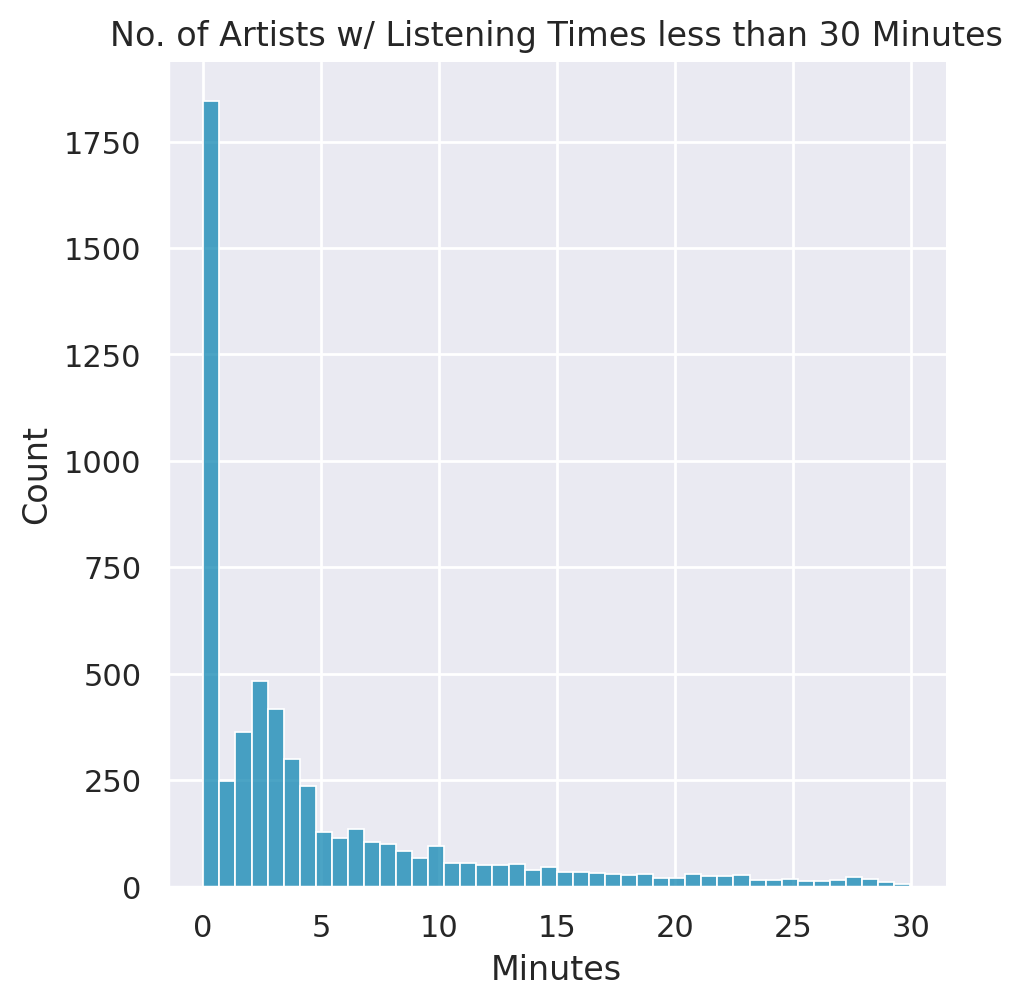

In [832]:
#Plotting the distribution of artists with a playtime less than 30 minutes

print("The top 5 artists with Playtime < 30 minutes:")
print()
print(artist_tracker_removed[0:5])
print()

sns.displot(artist_tracker_removed, x='Minutes', color='#0f86b2')
plt.title(f"No. of Artists w/ Listening Times less than {30} Minutes")
sns.set_style('darkgrid')
plt.show()

Majority of the artists in this dataset appear to who have a total playtime of less than 5 minutes. It's clear that omitting the artists in this dataset would have a negligible impact on the overall listening analysis.

In [833]:
print(artist_tracker[artist_tracker['Minutes'] <= 1000].info())
print('-x--x--x--x--x--x-')
print(artist_tracker[artist_tracker['Minutes'] > 1000].info())

<class 'pandas.core.frame.DataFrame'>
Index: 829 entries, 59 to 887
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   829 non-null    object 
 1   Minutes  829 non-null    float64
 2   Hours    829 non-null    float64
 3   Days     829 non-null    float64
dtypes: float64(3), object(1)
memory usage: 32.4+ KB
None
-x--x--x--x--x--x-
<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Artist   59 non-null     object 
 1   Minutes  59 non-null     float64
 2   Hours    59 non-null     float64
 3   Days     59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB
None


800+ artists have a playtime of less than or equal to 1000 minutes and 59 artists have a playtime of more than 1000 minutes. For ease of comprehension, the data will be visualized using the 1000 minute mark as well.

The top 5 artist with Playtime <= 1000 minutes:

           Artist     Minutes      Hours      Days
59     AsAP Rocky  983.077700  16.384628  0.682693
60  The Lumineers  977.729417  16.295490  0.678979
61   Clean Bandit  959.811467  15.996858  0.666536
62    Jack Harlow  955.424500  15.923742  0.663489
63         Avicii  937.001450  15.616691  0.650695



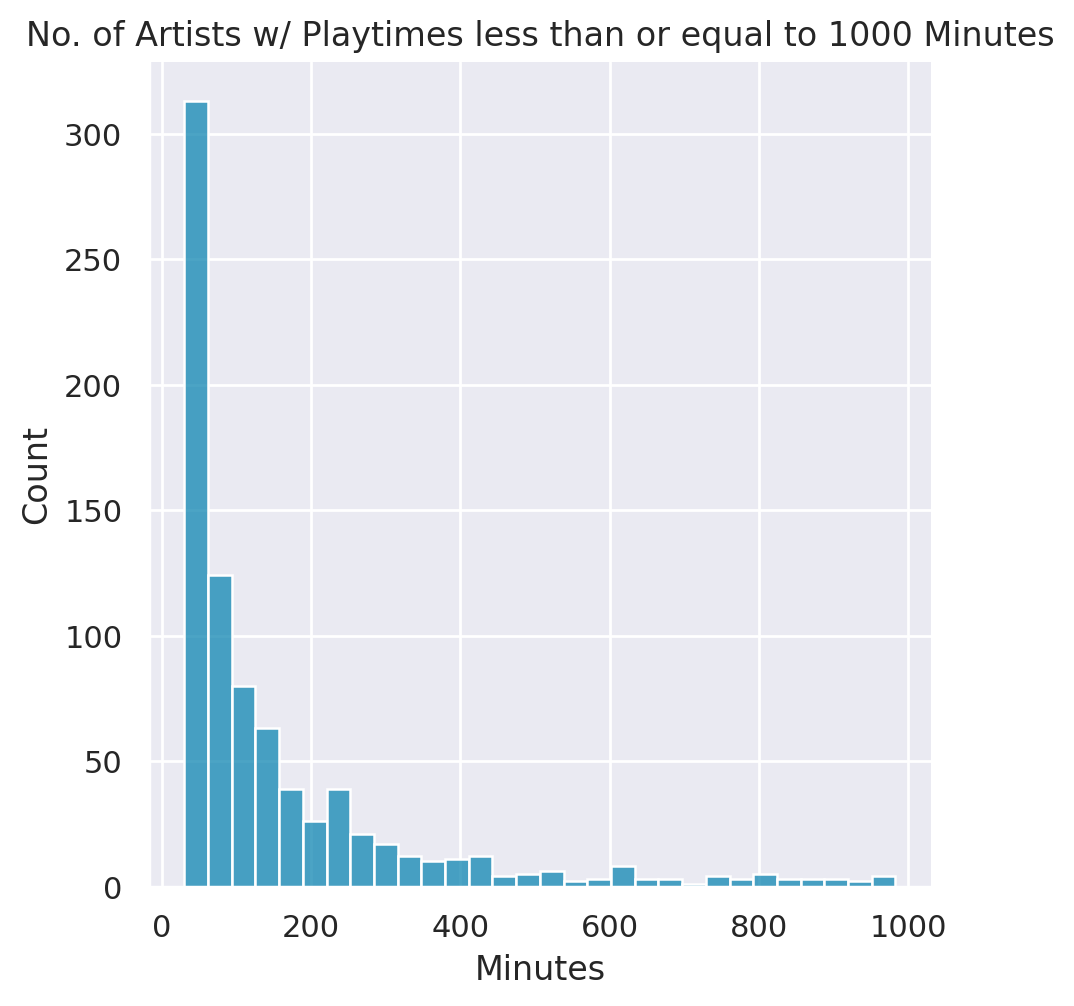

In [834]:
#Plotting the number of artists with a playtime less than or equal to a 1000 minutes
print("The top 5 artist with Playtime <= 1000 minutes:")
print()
print(artist_tracker[artist_tracker["Minutes"] <= 1000][0:5])
print()

sns.displot(artist_tracker[artist_tracker["Minutes"] <= 1000 ], x='Minutes', color='#0f86b2')
sns.set_theme(style="darkgrid")
plt.title(f"No. of Artists w/ Playtimes less than or equal to {1000} Minutes")
plt.show()

The top 5 artist with Playtime > 1000 minutes:

        Artist       Minutes       Hours       Days
0   The Weeknd  50059.321333  834.322022  34.763418
1       Khalid  20822.995617  347.049927  14.460414
2         Kygo  15621.056550  260.350942  10.847956
3        Drake  14196.610883  236.610181   9.858758
4  Post Malone   7775.800600  129.596677   5.399862



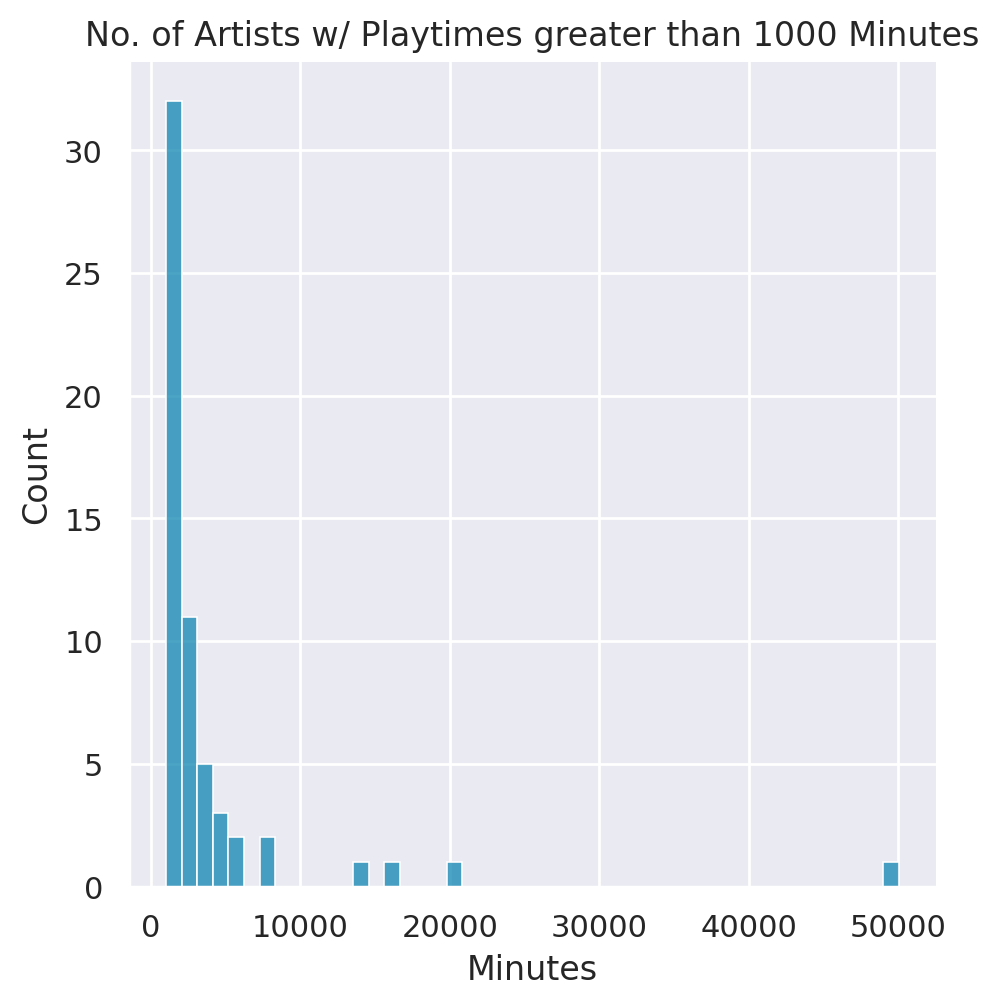

In [835]:
#Plotting the number of artists with a playtime greater than 1000 minutes
print("The top 5 artist with Playtime > 1000 minutes:")
print()
print(artist_tracker[artist_tracker["Minutes"] > 1000][0:5])
print()

sns.displot(artist_tracker[artist_tracker["Minutes"] > 1000], x='Minutes', color='#0f86b2')
sns.set_theme(style="darkgrid")
plt.title(f"No. of Artists w/ Playtimes greater than {1000} Minutes")
plt.show()

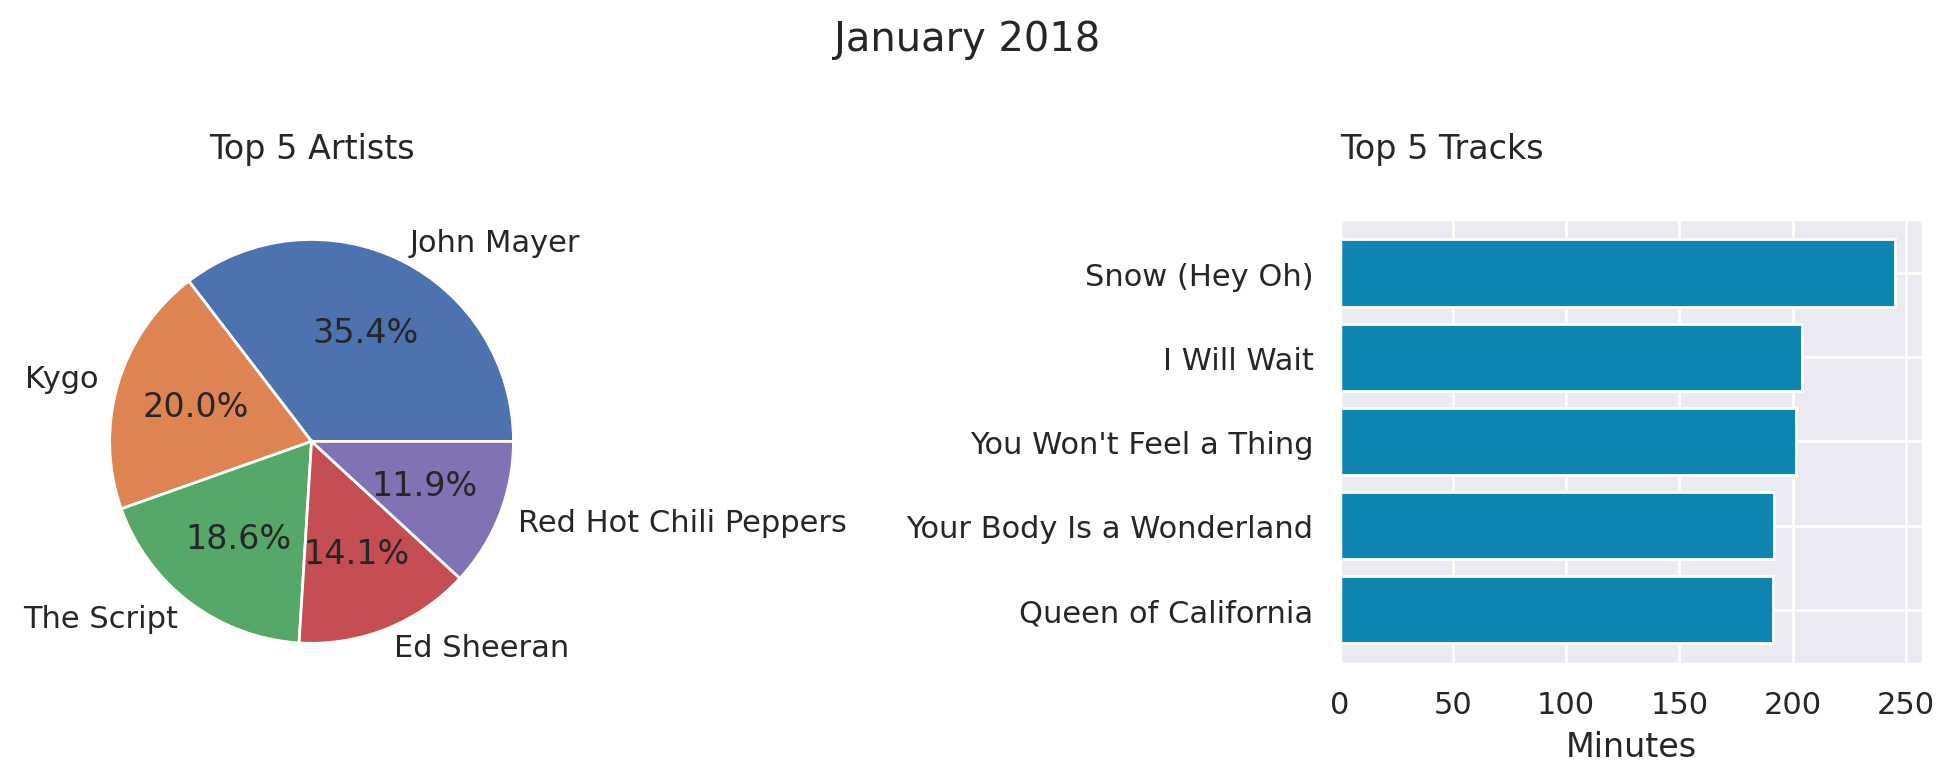

In [836]:
#Plotting the top 5 artists and tracks for a select month

top5_month(1, 2018)

### Data By Years

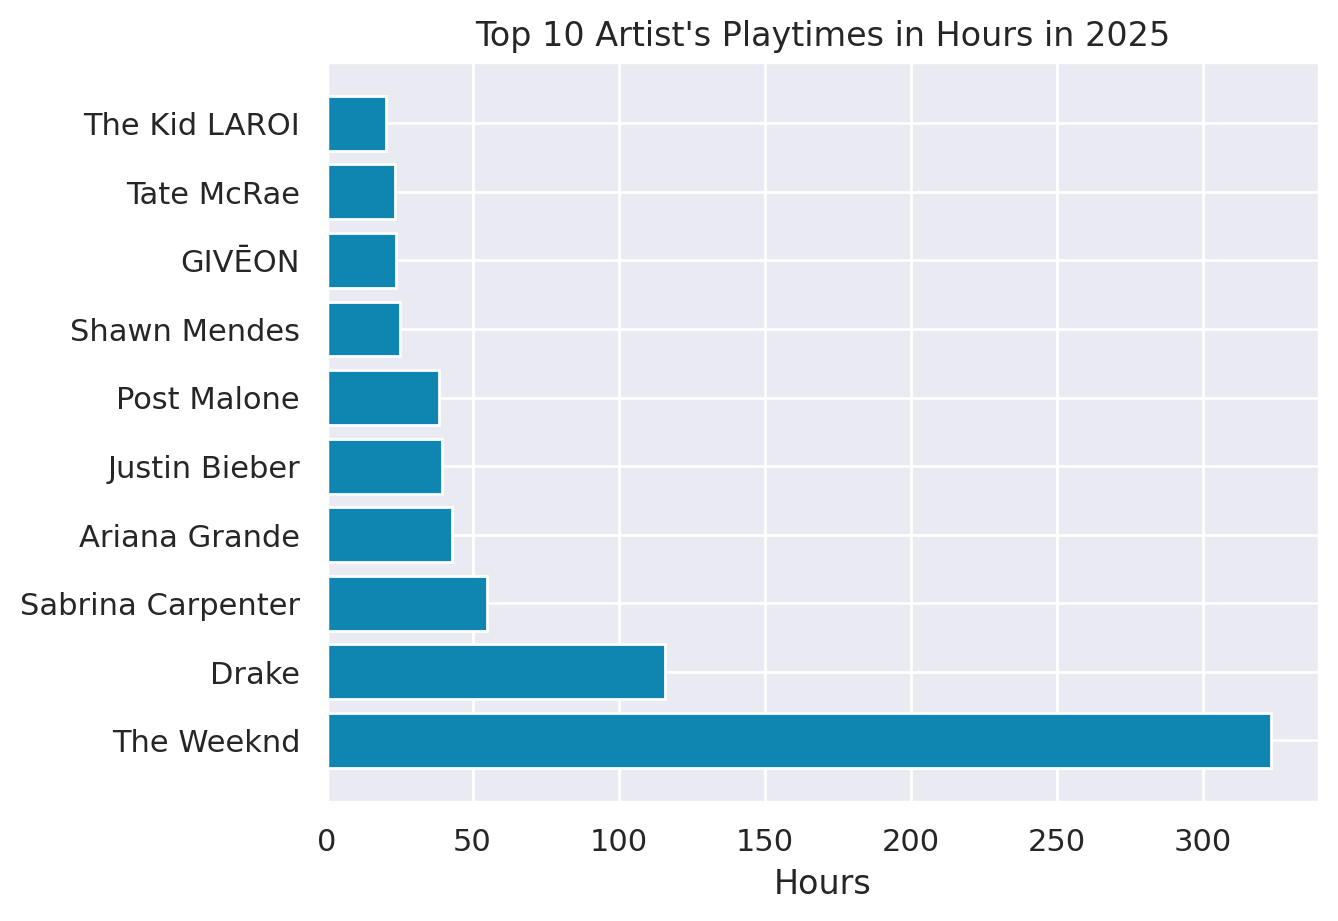


              Artist  Times_listened  Minutes  Hours
0         The Weeknd            8188  19407.9  323.5
1              Drake            3473   6956.5  115.9
2  Sabrina Carpenter            2112   3298.5   55.0
3      Ariana Grande            1605   2578.0   43.0
4      Justin Bieber            1665   2363.8   39.4
5        Post Malone            1837   2317.3   38.6
6       Shawn Mendes             876   1516.0   25.3
7             GIVĒON             883   1422.3   23.7
8         Tate McRae            1016   1397.9   23.3
9      The Kid LAROI             840   1212.0   20.2


In [837]:
#Displaying the Top 10 Artists for a select year

top_10(artist_2025)

<Figure size 1000x1000 with 0 Axes>

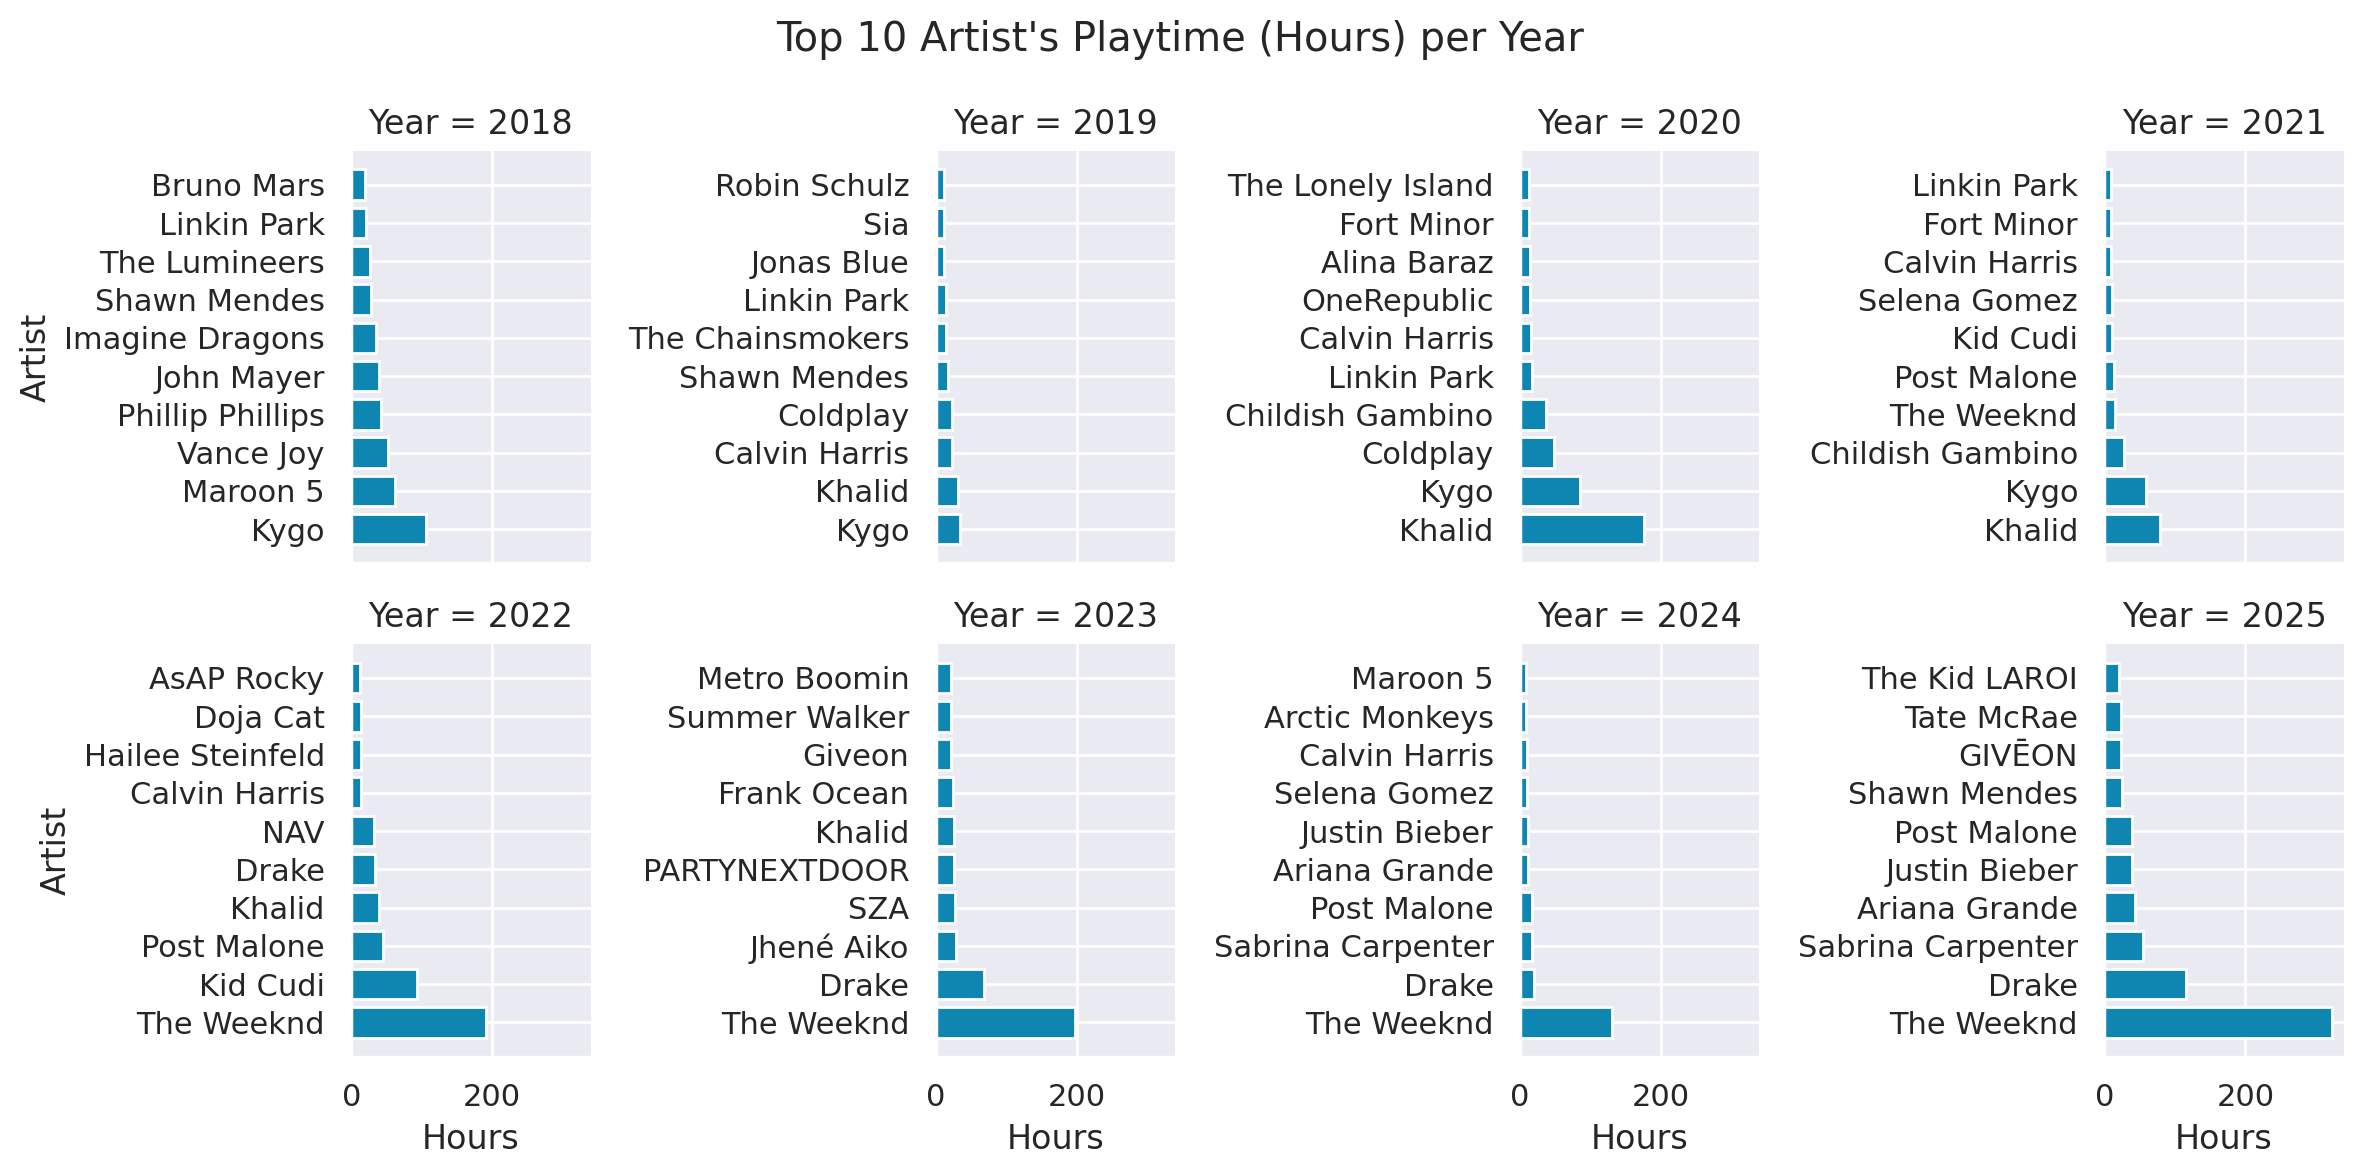

In [838]:
#Plotting my top 10 artists (according to the minutes played) for every year since 2018

a = sns.FacetGrid(data=top_10_all,col="Year",
                  sharey=False, sharex=True, col_wrap=4) #Kept the x axis common to allow for a better comparision among the years

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
a.map(plt.barh, 'Artist', 'Hours',color='#0f86b2')
a.set_axis_labels(x_var='Hours', y_var='Artist')
a.fig.suptitle("Top 10 Artist's Playtime (Hours) per Year")
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

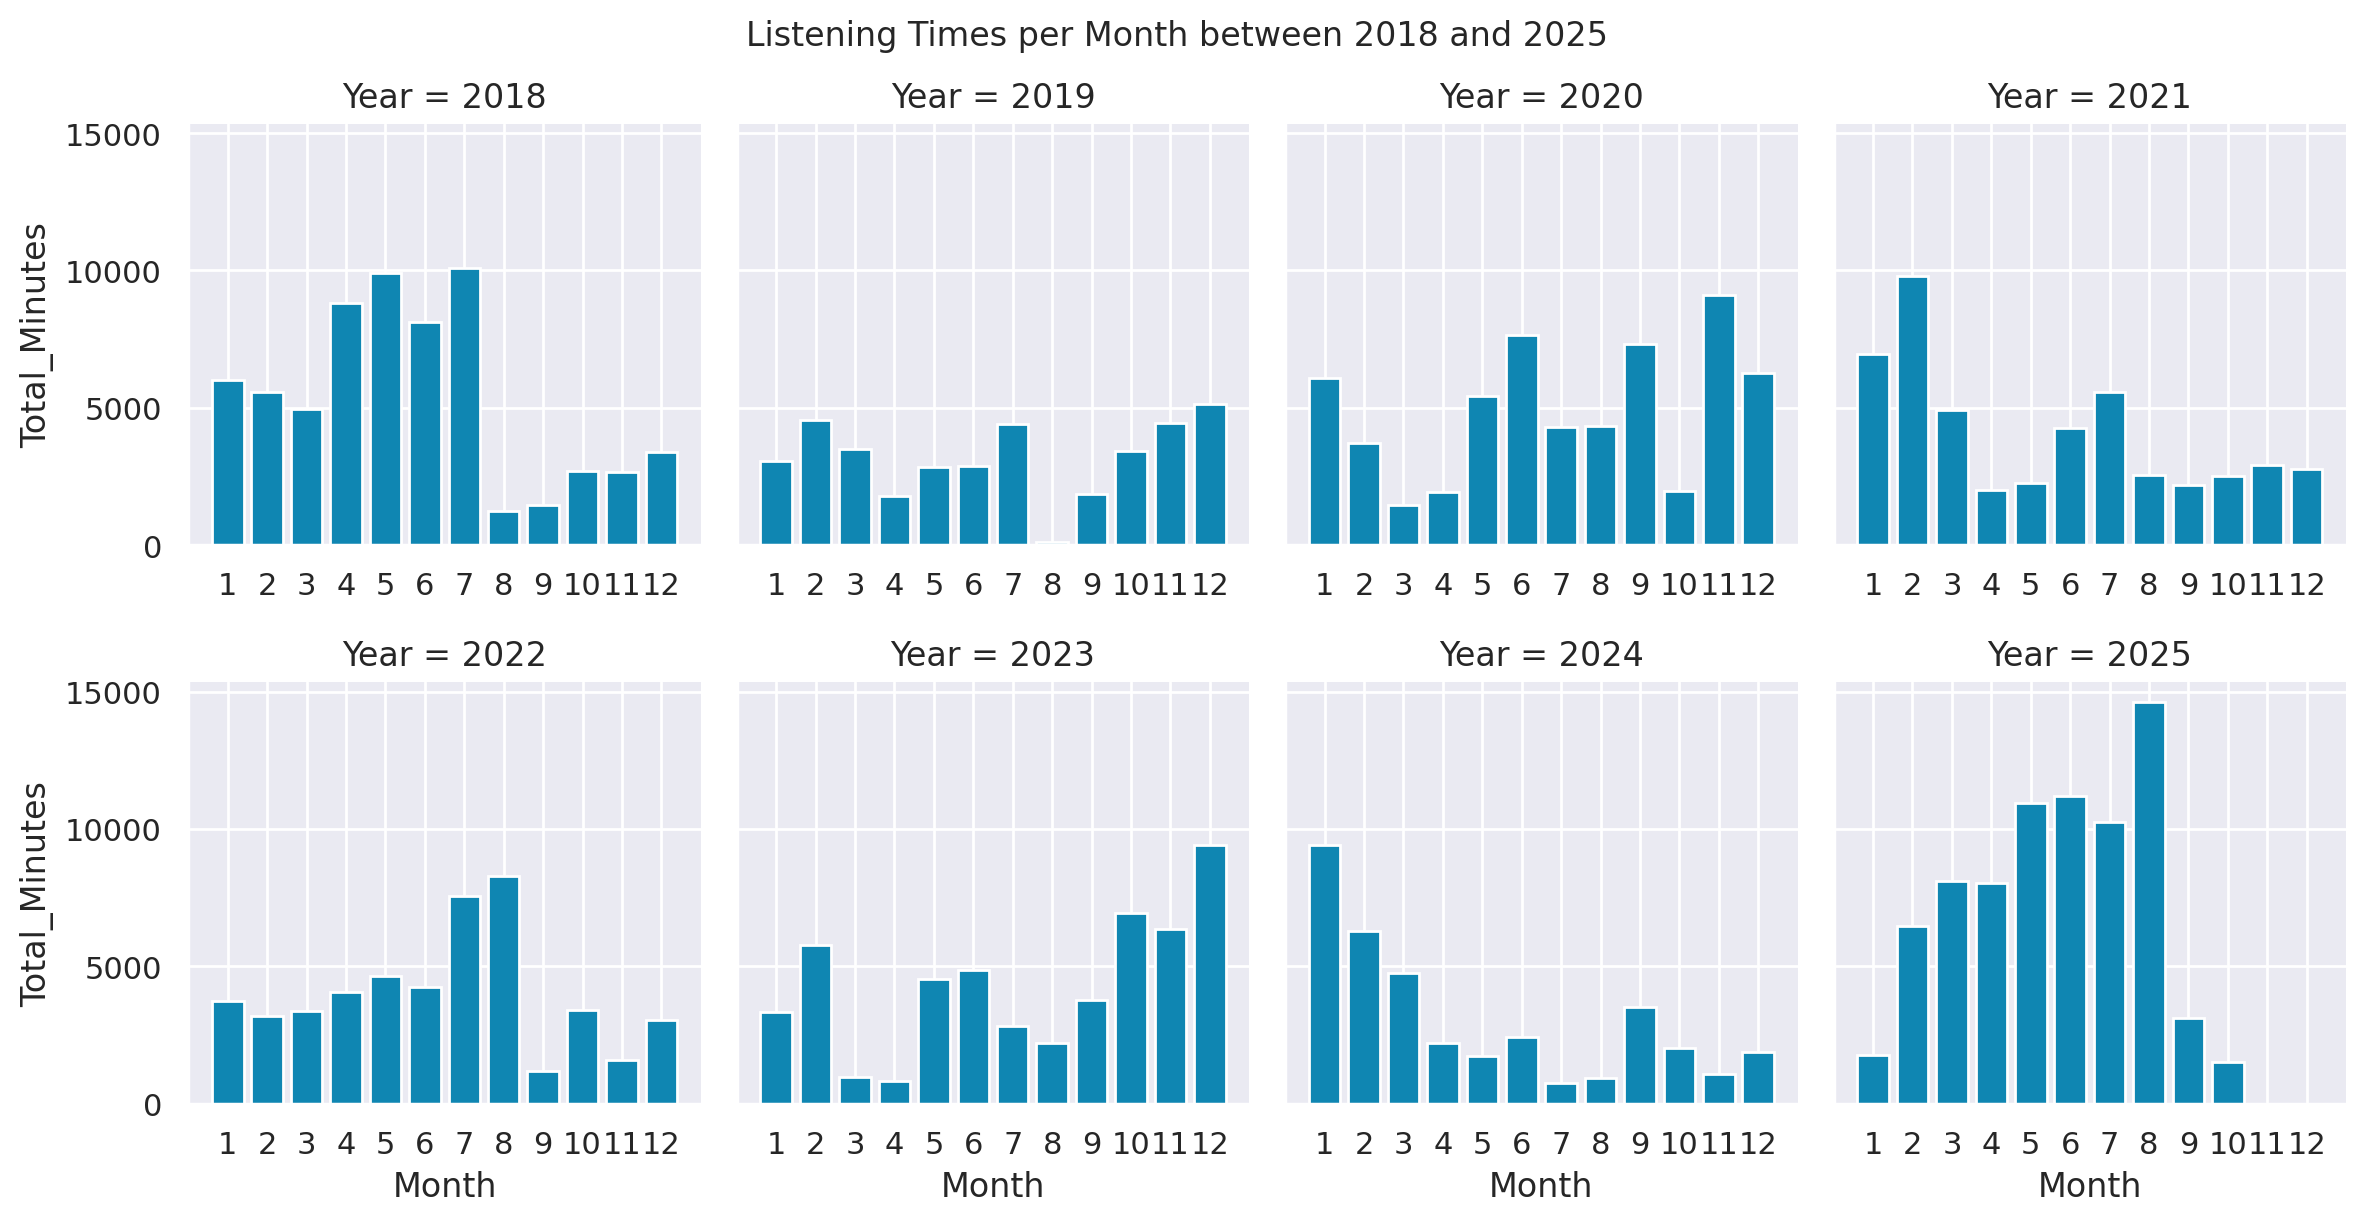

In [839]:
#Plotting my total music playtime in minutes per month for every year since 2018

plt.figure(figsize=(8,8))

b = sns.FacetGrid(playtime_by_month, col='Year', col_wrap=4, sharex=False, sharey=True)
b.map(plt.bar, 'Month', 'Total_Minutes', color='#0f86b2')
b.set(xlim=(0, 13), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
b.fig.suptitle("Listening Times per Month between {} and {} ".format(playtime_by_month["Year"].min(),
                                  playtime_by_month["Year"].max()), y=1.02, size=12)

plt.show()

#### Artist Listening Progression

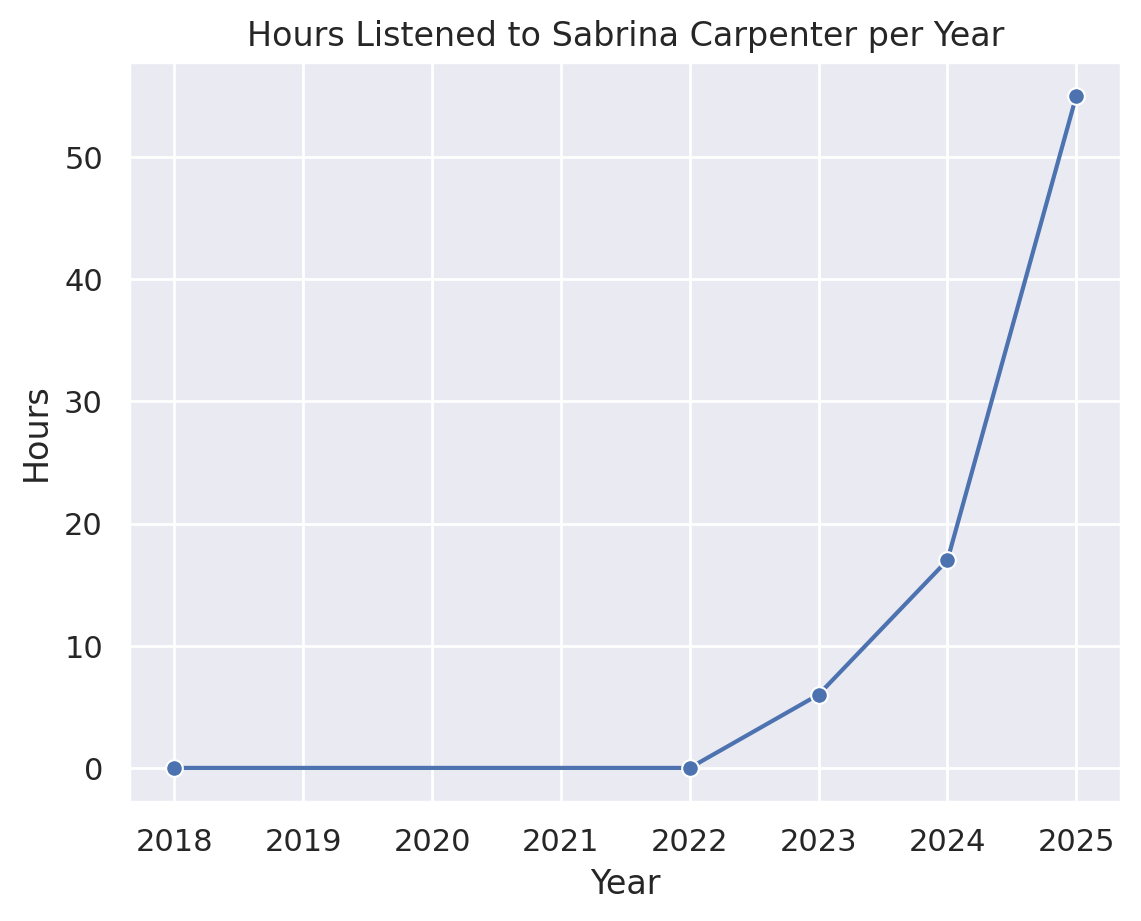

In [840]:
#Plotting the trend in my playtimes per year for a select artist

artist_listening_progression(artist_years, "Sabrina Carpenter", 2018, 2025) #Calling the artist_listening_progression function

#### Listening Trends

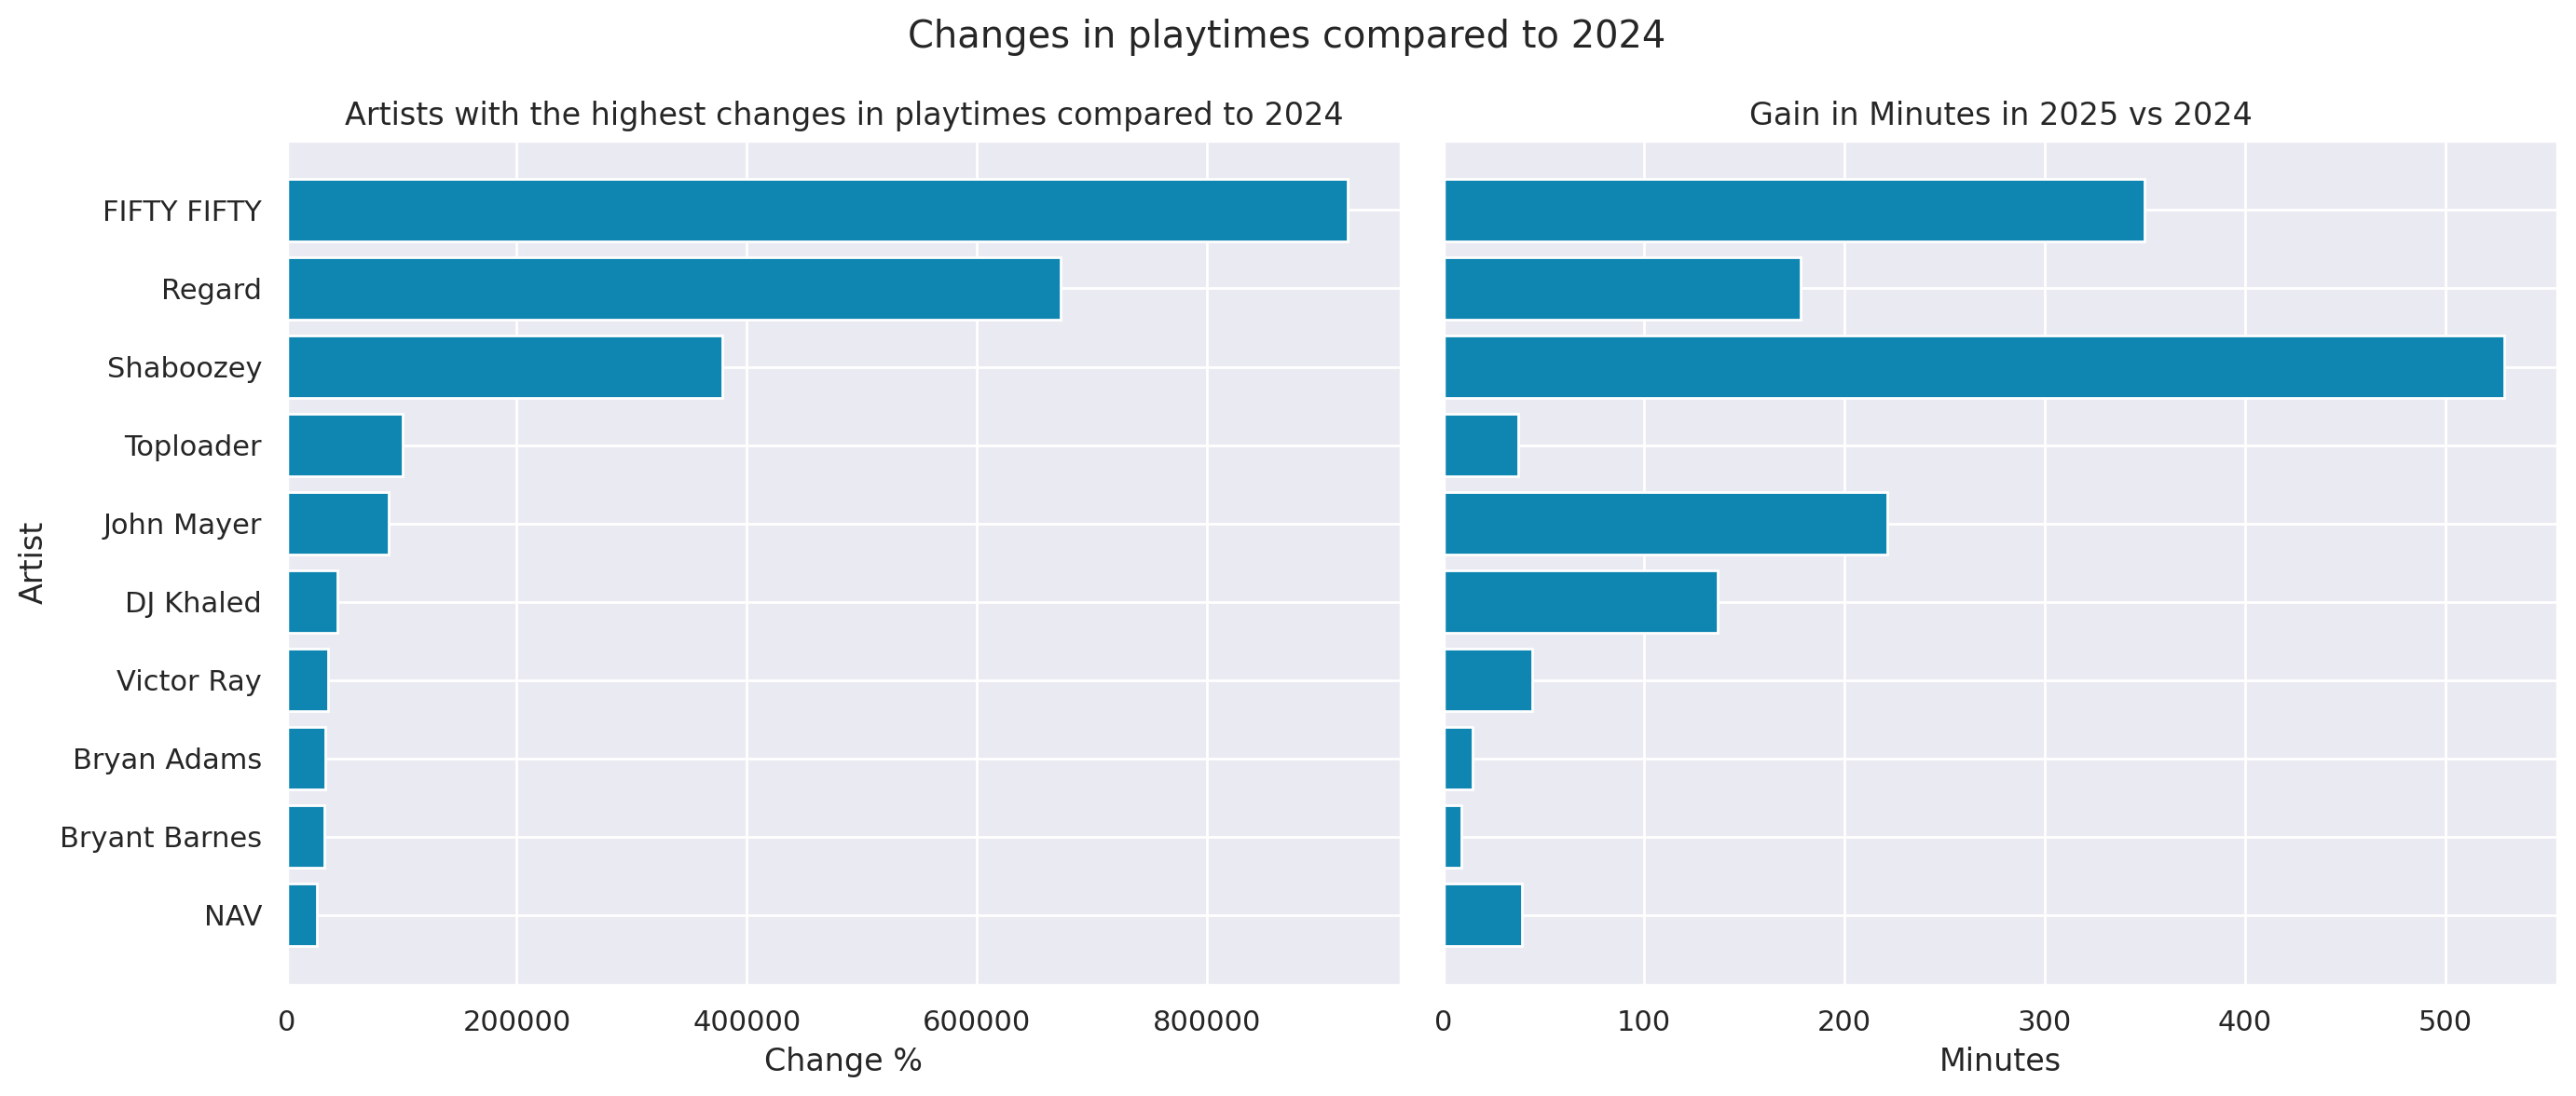

In [841]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].barh(data=changes_df[0:10], y='Artist', width='Change_%', color='#0f86b2')
ax[0].set_title("Artists with the highest changes in playtimes compared to 2024")
ax[0].set_xlabel('Change %')
ax[0].yaxis.set_inverted(True)
ax[0].set_ylabel("Artist")


comparision_2025 = ax[1].barh(data=changes_df[0:10],  width = changes_df[2025][0:10], y='Artist', color='#0f86b2')
ax[1].set_xlabel('Minutes')
ax[1].set_yticklabels('')
ax[1].yaxis.set_inverted(True)
ax[1].set_title("Gain in Minutes in 2025 vs 2024")


plt.suptitle("Changes in playtimes compared to 2024")
plt.tight_layout()
plt.show()

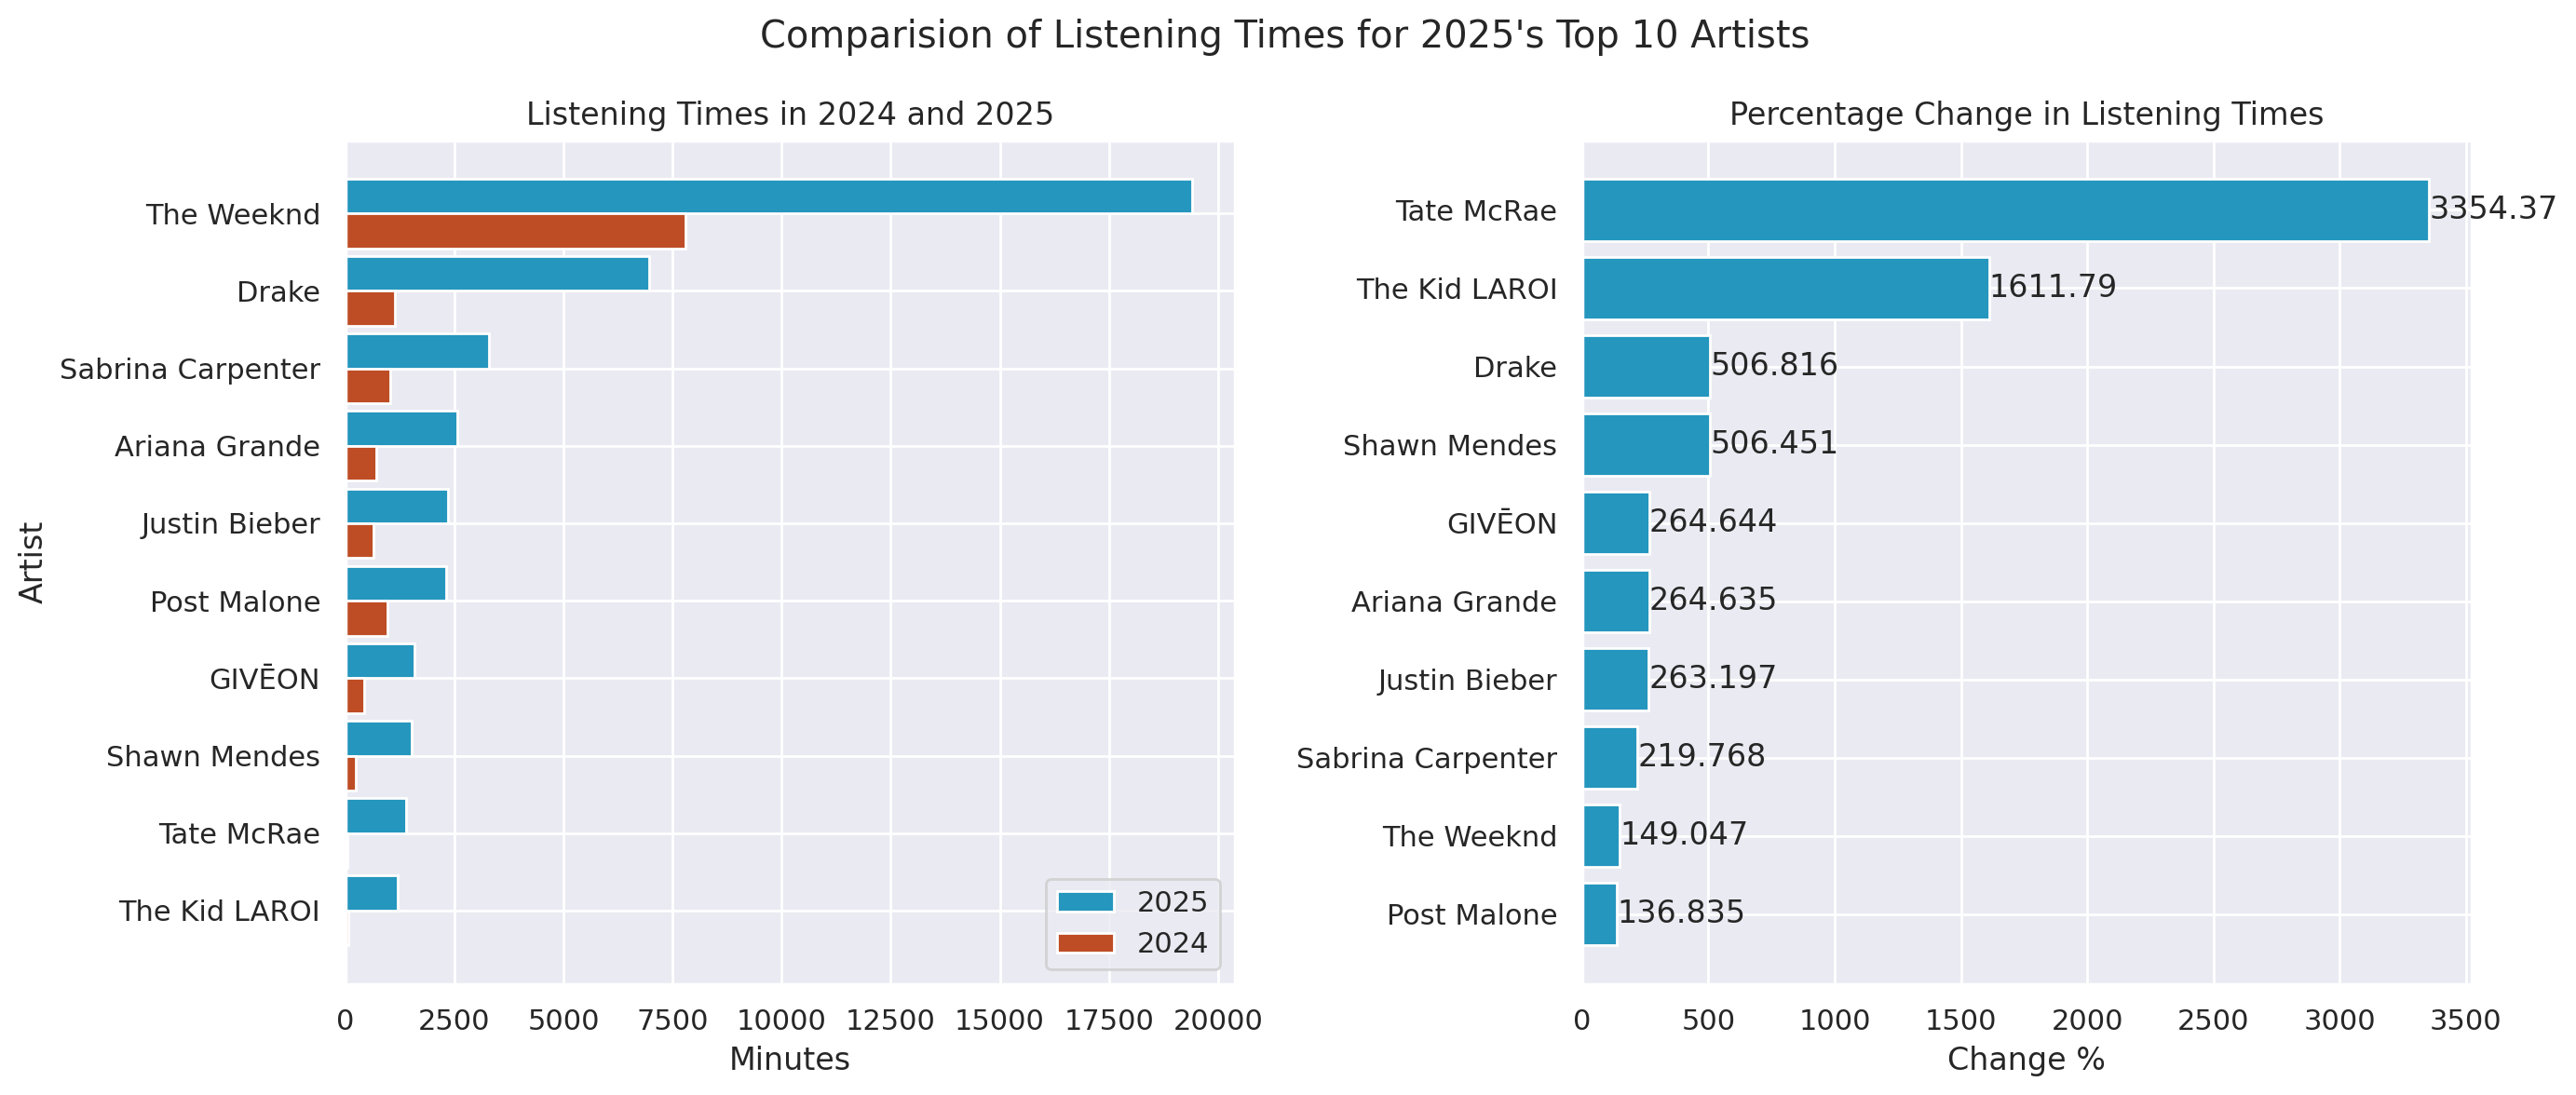

In [881]:
initial = np.arange(10)
height = 0.45
offset = initial + height

fig, ax = plt.subplots(1,2, figsize=(14,6))

dataset = changes_df.sort_values(2025, ascending=False)[0:10]

listening_2025 = ax[0].barh(data=dataset, y=initial, width=dataset[2025], height=height, color='#2596be')
listening_2024 = ax[0].barh(data=dataset, y=offset, width=dataset[2024], height=height, color='#be4d25')
ax[0].legend([2025, 2024])
ax[0].set_yticks(initial+height/2)
ax[0].set_yticklabels(dataset["Artist"])
ax[0].yaxis.set_inverted(True)
ax[0].set_xlabel("Minutes")
ax[0].set_title("Listening Times in 2024 and 2025")
ax[0].set_ylabel("Artist")

bars = ax[1].barh(data=dataset.sort_values('Change_%'), y=initial+height/2, width='Change_%', color='#2596be')
ax[1].set_yticks(initial+height/2)
ax[1].set_yticklabels(dataset.sort_values('Change_%')["Artist"])
#ax[1].yaxis.set_inverted(True)
ax[1].set_xlabel("Change %")
ax[1].set_title("Percentage Change in Listening Times")
ax[1].bar_label(bars)
fig.suptitle("Comparision of Listening Times for 2025's Top 10 Artists")

plt.tight_layout()
plt.show()

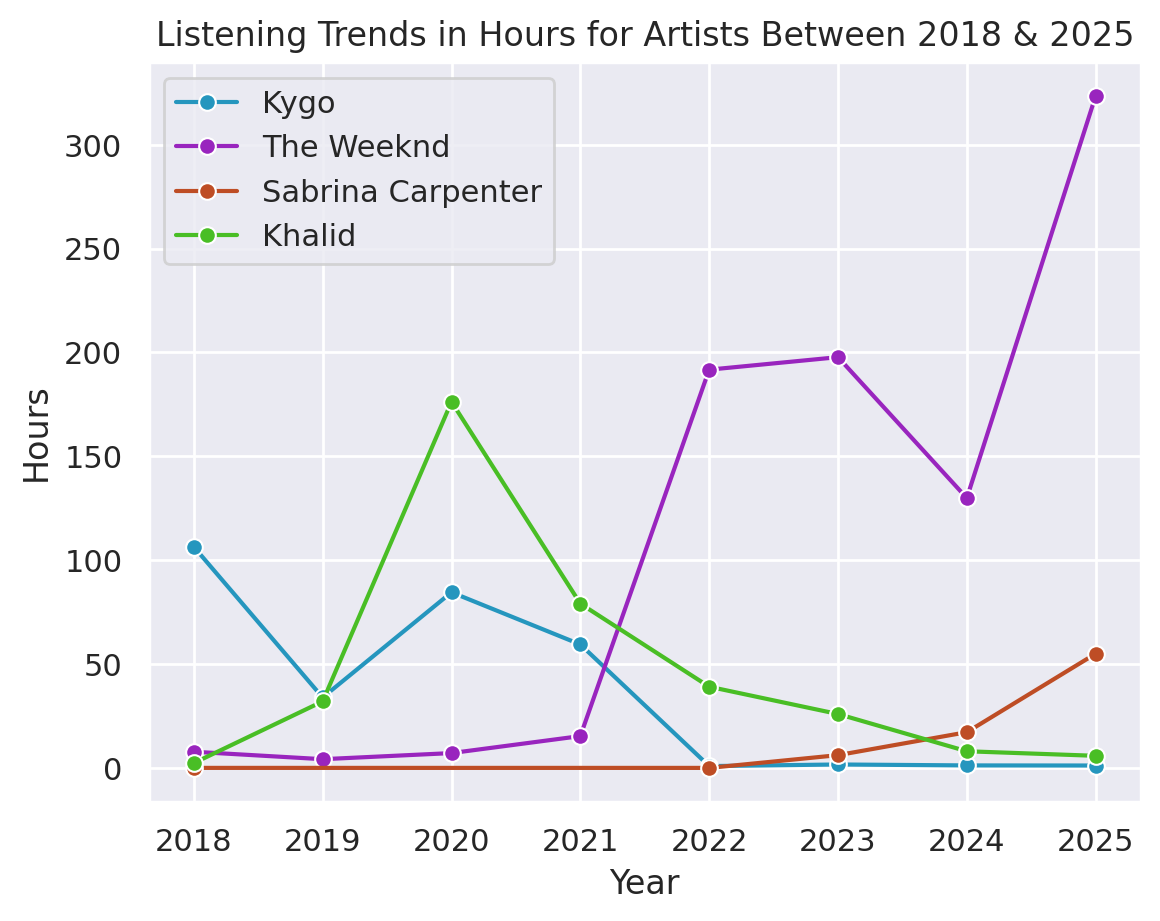

In [843]:
#Plotting listening trends for select artists between 2018 and 2025

over_the_years(2018, 2025, ["Kygo", "The Weeknd", "Sabrina Carpenter", "Khalid"]) #Calling the over_the_years function

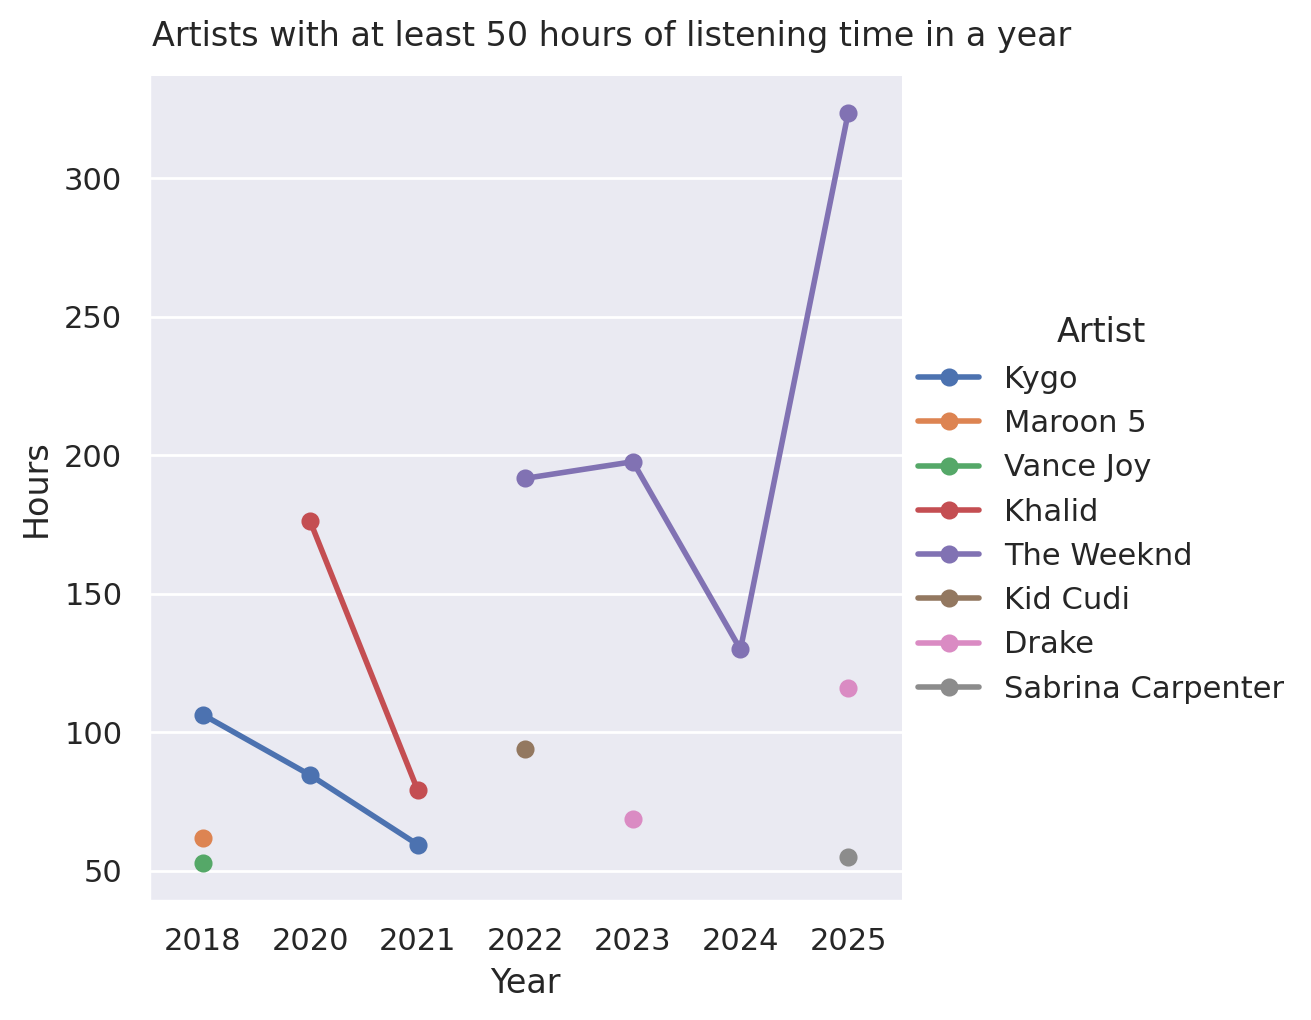

In [844]:
# Plotting artists with playtimes of at least 50 hours or more in a year

minimum = 50
c = sns.catplot(data=artist_years[artist_years["Hours"] >= minimum ], x="Year", y="Hours", hue="Artist", kind='point',linewidth=2)
c.fig.suptitle('Artists with at least {} hours of listening time in a year'.format(minimum), y=1.02, size=12)
sns.set_theme(style='darkgrid')
sns.color_palette(palette='Paired')
plt.show()

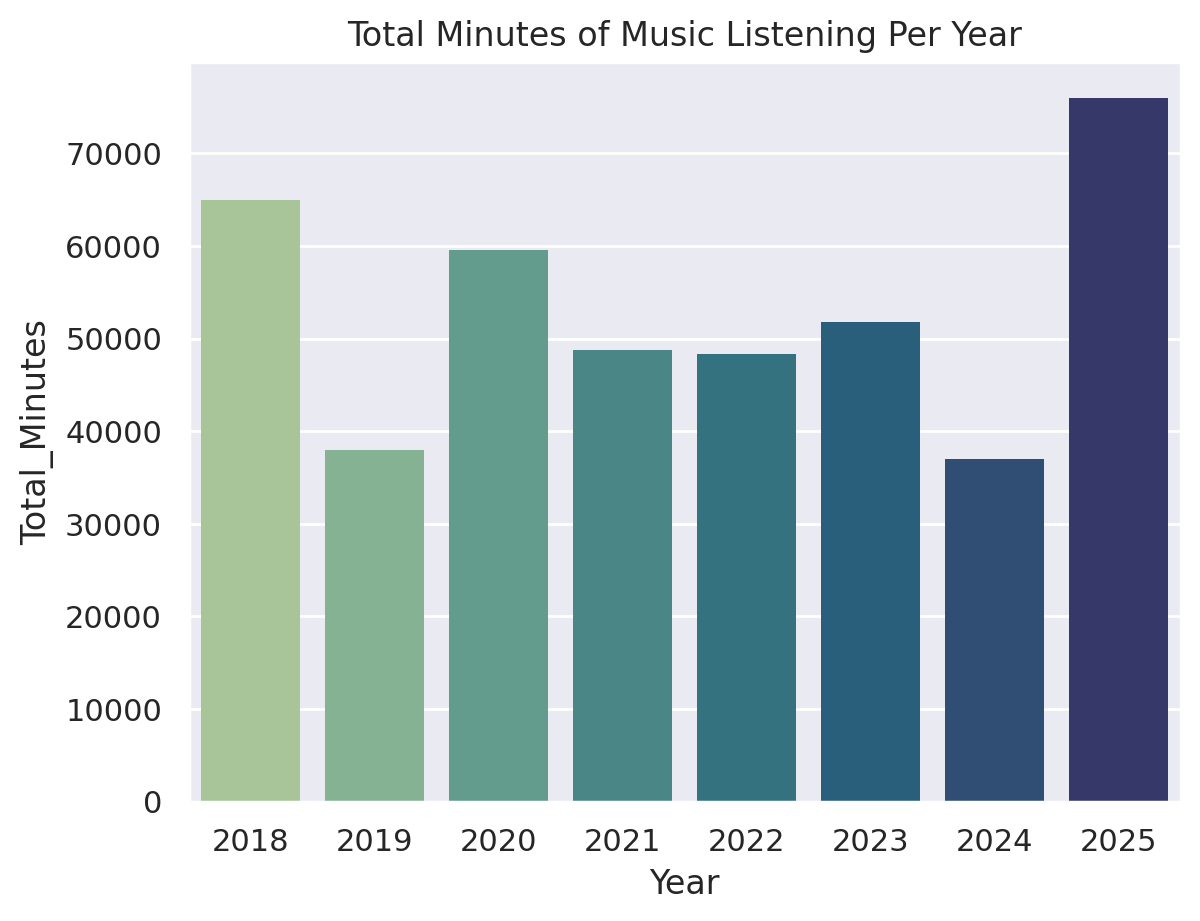

In [845]:
#Plotting Total Minutes of Music Listening Per Year

sns.barplot(x="Year", y='Total_Minutes', data=listening_by_year, hue='Year', legend=None, palette='crest', edgecolor='none')
plt.title("Total Minutes of Music Listening Per Year")
sns.set_theme(style='darkgrid')
plt.show()

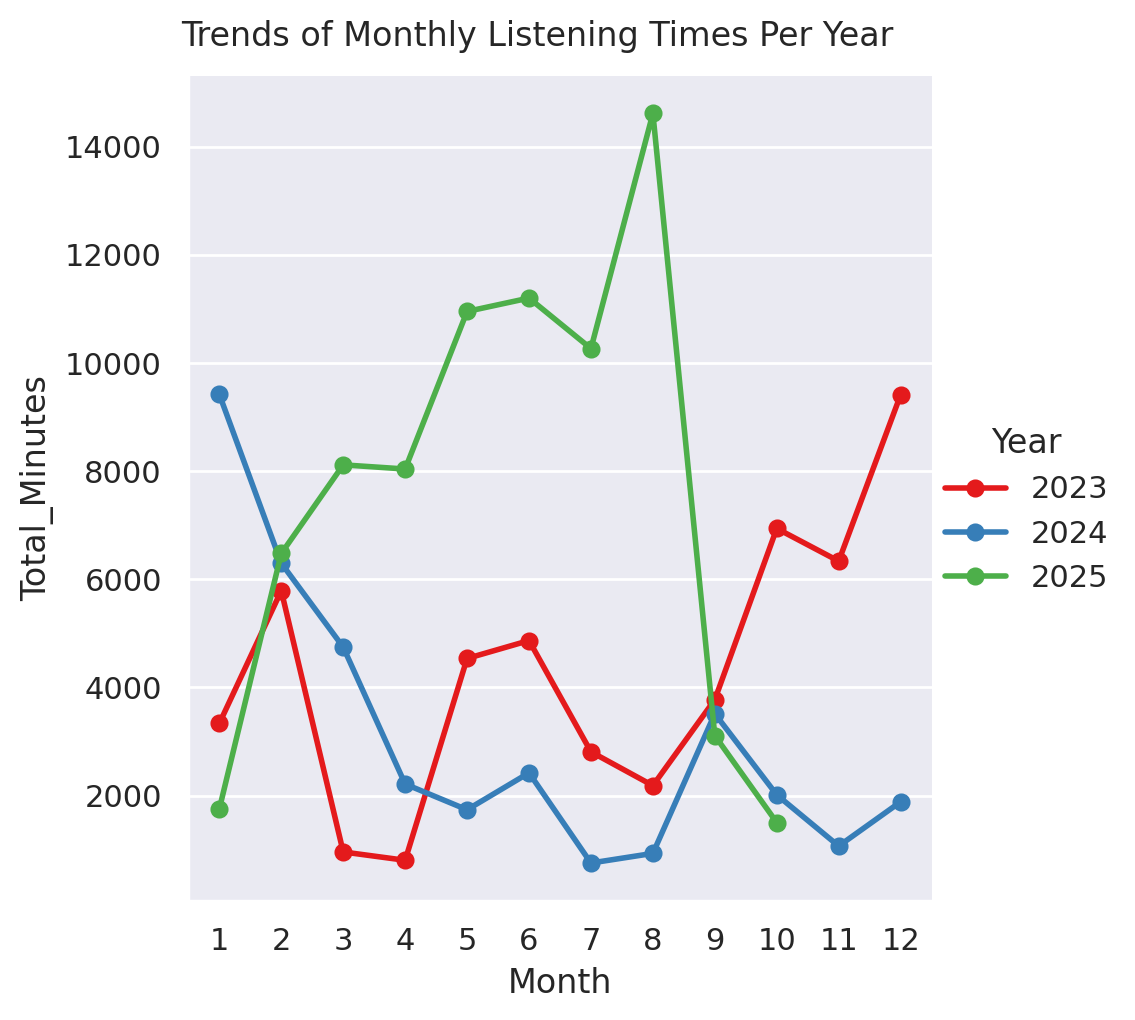

In [846]:
#Plotting Trends of Monthly Listening Times Per Year

d = sns.catplot(playtime_by_month[playtime_by_month["Year"] >= 2023], x="Month", y="Total_Minutes", hue="Year",
                kind="point", palette='Set1', linewidth=2)
d.fig.suptitle("Trends of Monthly Listening Times Per Year", y=1.02, size=12)
sns.set_theme(style='darkgrid')
plt.show()

### All Time Data

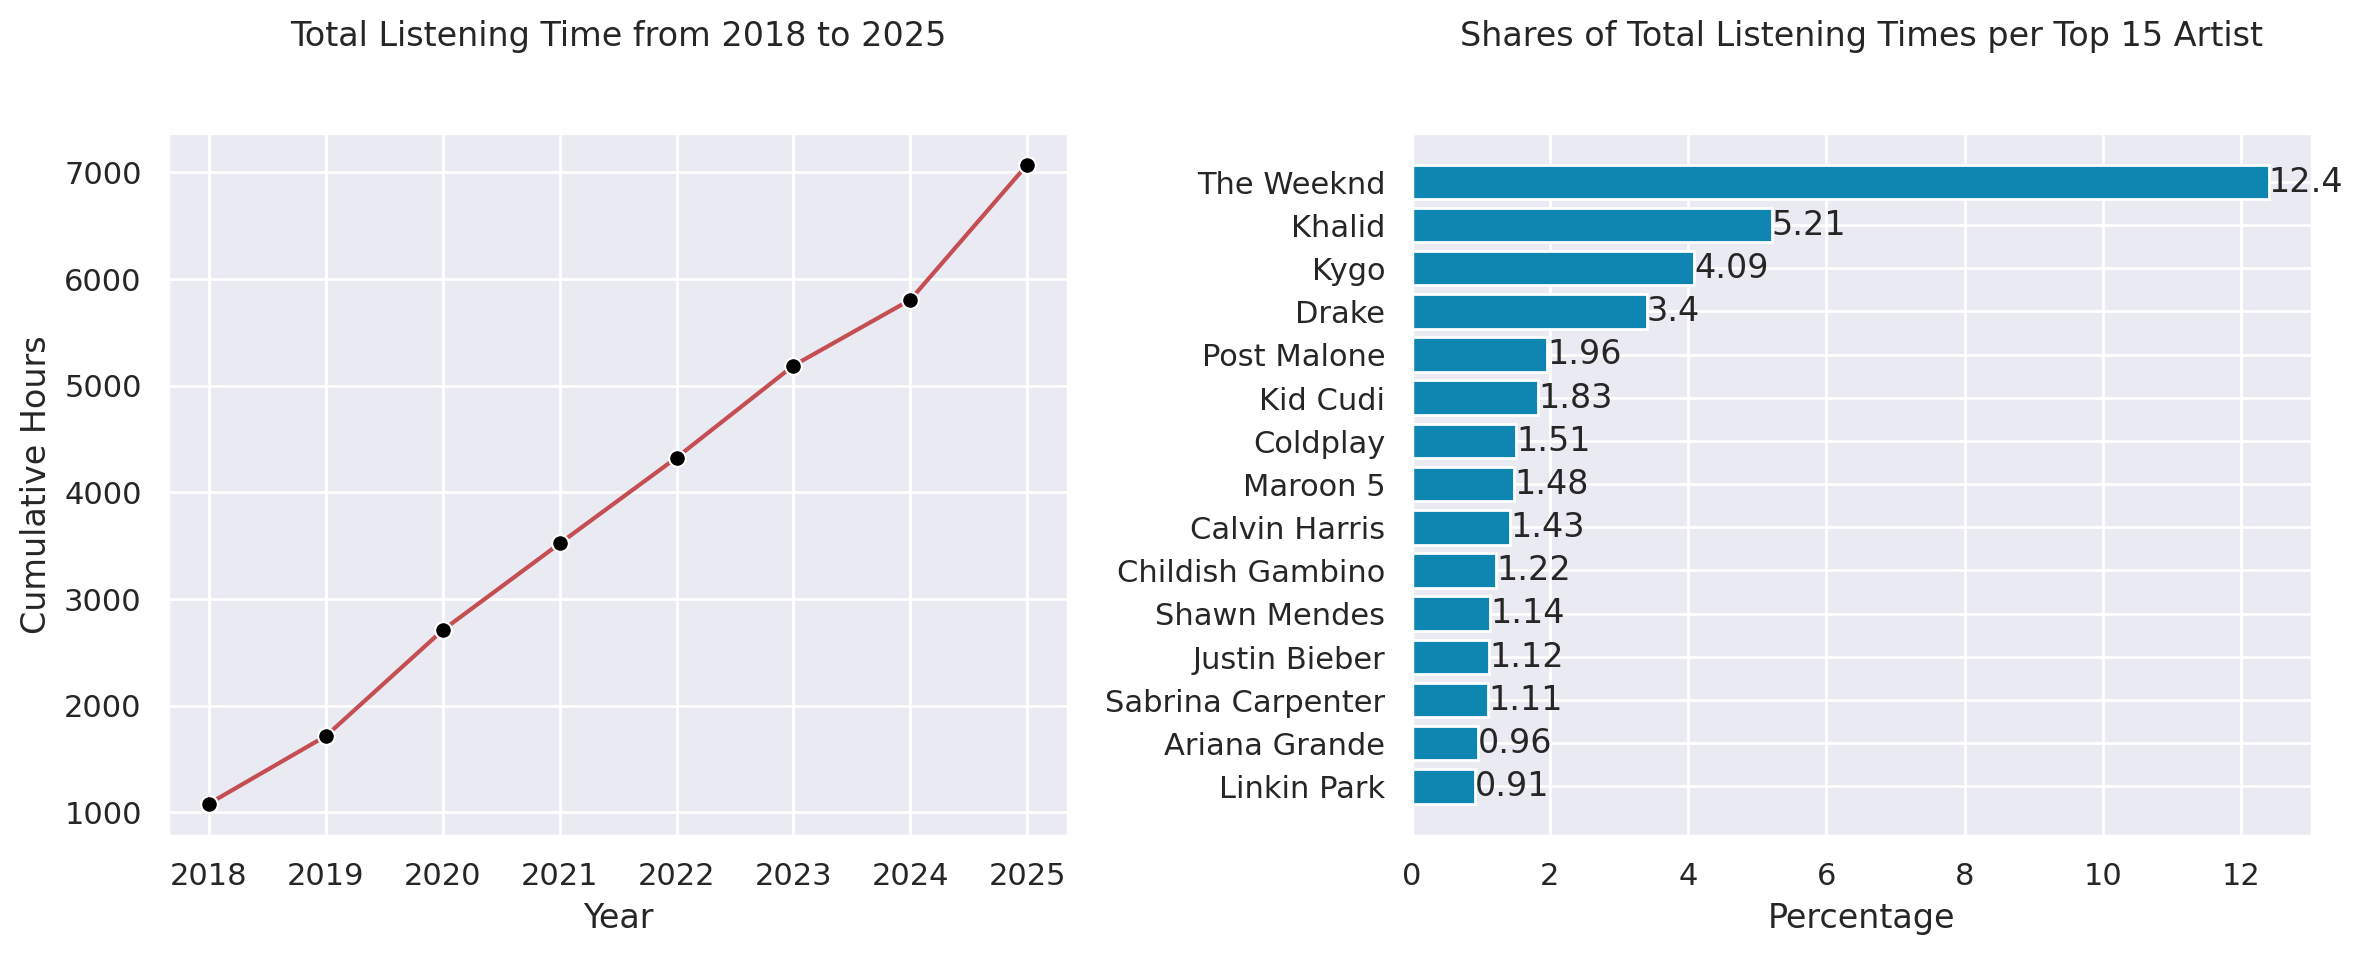

In [847]:
# Plotting the cumulative listening times over the years

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(data=listening_by_year, x="Year", y="Cumulative_Total_Hours", ax=axes[0], color='r', marker='o', markerfacecolor='black')
axes[0].set_title('Total Listening Time from {} to {}'.format(listening_by_year['Year'].min(), listening_by_year['Year'].max()), y=1.1)
axes[0].set_ylabel("Cumulative Hours")


bars = axes[1].barh(data=artist_total_hours_top15, y='Artist', width='Percentage of Total Hours', color='#0f86b2')
axes[1].set_title('Shares of Total Listening Times per Top 15 Artist', y=1.1)
axes[1].set_xlabel('Percentage')
axes[1].bar_label(bars)
axes[1].yaxis.set_inverted(True)

plt.tight_layout()
plt.show()

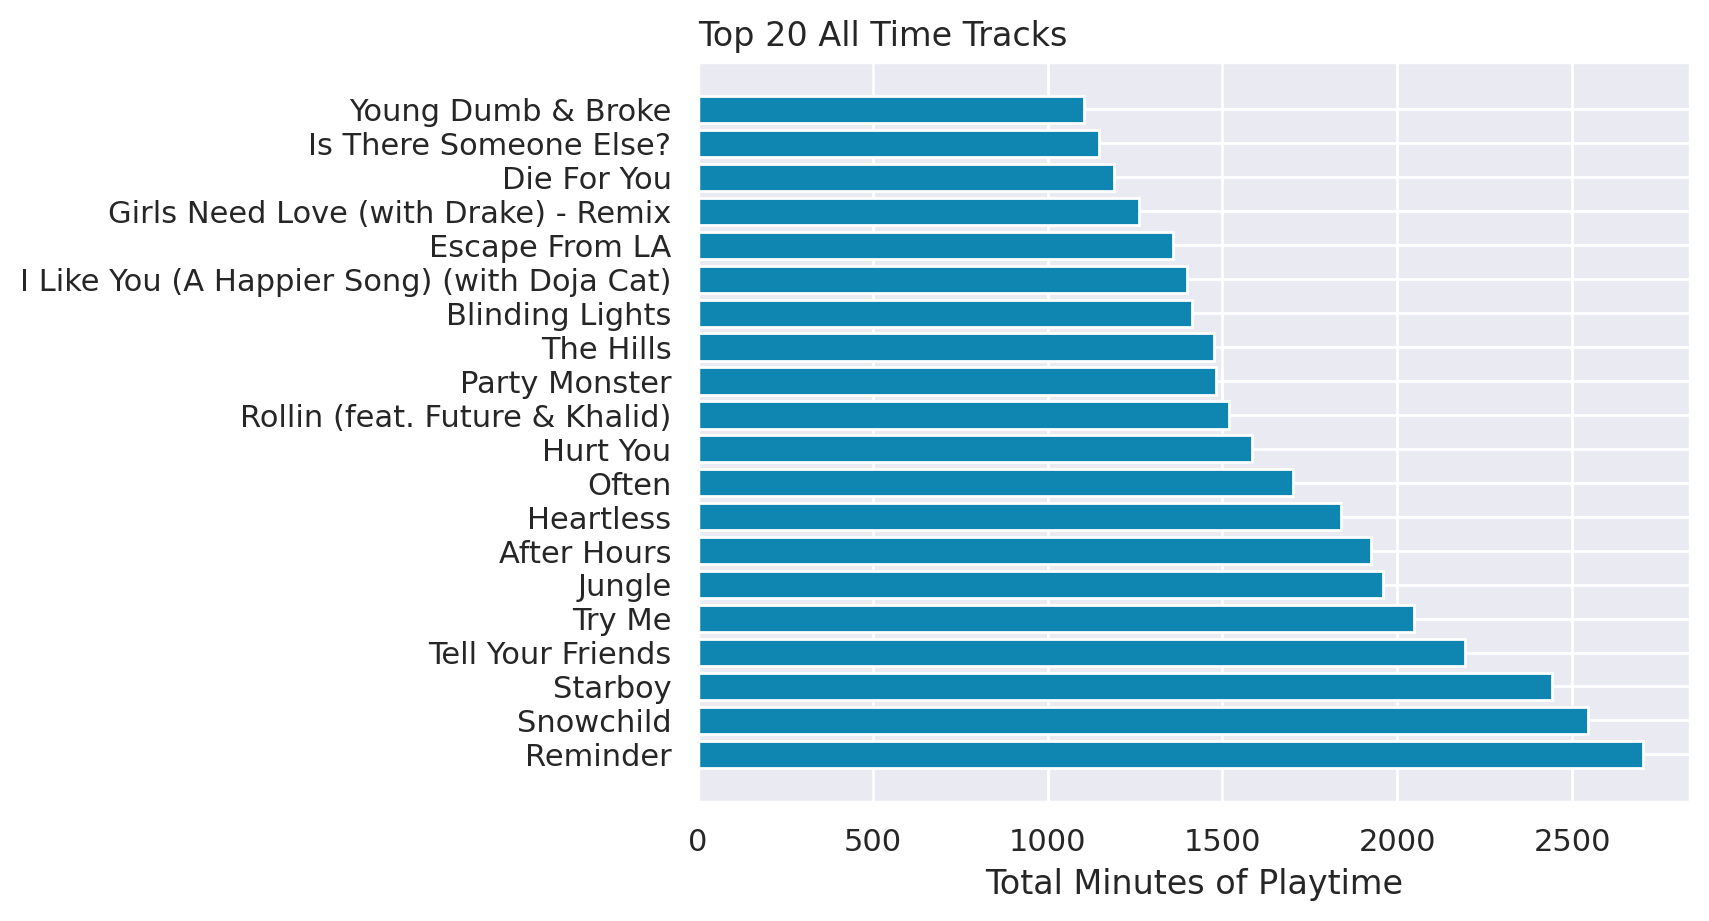

In [848]:
#Plotting the 20 of my most played songs since 2018 against their respective playtimes in minutes

plt.barh(data = num_of_unique_songs[0:20], y="Track_name", width = "Minutes_Played", color='#0f86b2')
plt.title(f"Top {20} All Time Tracks ", loc='Left')
sns.set_style('darkgrid')
plt.xlabel("Total Minutes of Playtime")
plt.show()

In [849]:
end_time = time.time()
#print("Execution time: ", end_time - start_time,"secs")